# Simulation Design

_Control Complexity with Modular DGPs_

In [4]:
# Re-import necessary libraries after code execution reset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

# Use a serif font and increase font sizes for readability
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [5]:
def simulate_rl_panel(stage: int, seed: int = 42) -> pd.DataFrame:
    """
    Simulates panel data under three staged DGPs for evaluating RL donor selection.

    Parameters:
    - stage (int): Simulation stage (1 to 3)
        1 = Static DGP, no regime change
        2 = Fixed A parameters with Gaussian bump for shock
        3 = Fully randomized parameters with Gaussian bump for A
    - seed (int): Random seed for reproducibility

    Returns:
    - pd.DataFrame: Simulated panel data
    """
    np.random.seed(seed)
    units = [chr(65 + i) for i in range(10)]  # Units A–J
    periods = pd.date_range(start="1960-03-01", end="2024-12-01", freq="3MS") # 260 obs
    T = len(periods)

    # Parameters
    p, q = 0.98, 0.6
    alpha = 0.09
    beta = 2
    sigmay = 1
    sigmax = 0.5

    data = []

    for unit in units:
        if stage == 2 and unit == "A":
            rho_i = 0.8
            gamma_i = 1.4
        else:
            rho_i = np.random.uniform(0.4, 0.9)
            gamma_i = np.random.uniform(0.5, 1.5)

        y = np.zeros(T)
        delta = np.zeros(T)
        x = np.zeros(T)

        signal = np.sin(np.linspace(0, 6 * np.pi, T))

        if stage == 1:
            x = np.random.normal(0, sigmax, T)
            delta[:] = 0

        elif stage in [2, 3]:
            if unit == "A":
                center_time = pd.Timestamp("2015-06-01")  # midpoint of 2010–2019
                center_idx = np.argmin(np.abs(periods - center_time))
                width = 8  # 8 quarters is 2 years, on each side is roughly 2013–2017
                base_level = -4
                scale = 10

                bump = base_level + scale * np.exp(-((np.arange(T) - center_idx) ** 2) / (2 * width ** 2))
            else:
                bump = np.zeros(T)

            x = gamma_i * (signal + bump) + np.random.normal(0, sigmax, T)

        for t in range(1, T):
            X = x[t - 1]
            y_lag = y[t - 1]

            if stage == 1:
                delta[t] = 0
            else:
                if delta[t - 1] == 0:
                    prob = 1 - (p - alpha * X)
                else:
                    prob = q
                prob = np.clip(prob, 0, 1)
                delta[t] = np.random.binomial(1, prob)

            epsilon = np.random.normal(0, sigmay)
            y[t] = rho_i * y[t - 1] + beta * delta[t] + epsilon

            data.append({
                'unit': unit,
                'period': periods[t],
                'y': y[t],
                'y_lag': y_lag,
                'delta': delta[t],
                'x': x[t],
                'x_lag': x[t - 1],
                'rho_i': rho_i,
                'gamma_i': gamma_i,
                'stage': stage
            })

    df = pd.DataFrame(data)
    df['period'] = pd.to_datetime(df['period'])  # ensure datetime format
    return df

## Plot simulated data for Target A

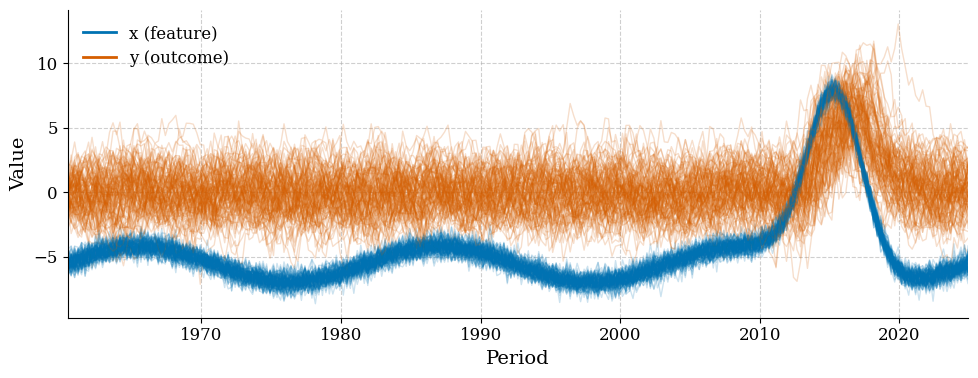

In [6]:
stage = 2  
n_simulations = 100
fig, ax = plt.subplots(figsize=(10, 4))

for seed in range(n_simulations):
    df_sim = simulate_rl_panel(stage=stage, seed=seed)
    df_sim.set_index('period', inplace=True)
    df_A = df_sim[df_sim['unit'] == 'A']
    ax.plot(df_A.index, df_A['x'], alpha=0.2, color='#0072B2', linewidth=1)
    ax.plot(df_A.index, df_A['y'], alpha=0.2, color='#D55E00', linewidth=1)

# Add titles and labels
#ax.set_title(f'Simulated Trajectories for Unit A over {n_simulations} Simulations')
ax.set_xlim(df_A.index.min(), df_A.index.max())
ax.set_xlabel('Period')
ax.set_ylabel('Value')

# Custom legend using Line2D
legend_elements = [
    Line2D([0], [0], color='#0072B2', lw=2, label='x (feature)'),
    Line2D([0], [0], color='#D55E00', lw=2, label='y (outcome)')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=False)

# Tighter layout and export-ready
plt.tight_layout()
plt.savefig(f"results/regime/stage{stage}/figures/stage{stage}_simulated_data.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# Monte Carlo Loop Design

In [4]:
import os
from OptimalPanel.optimizer import OptimalBundleRL
from tqdm import tqdm

# ---- Configurable Parameters ----
n_simulations = 100
total_epochs = 500
stage = 3  # Simulation stage to use
base_dir = f"results/regime/stage{stage}"

model_dir = os.path.join(base_dir, "models")
data_dir = os.path.join(base_dir, "data")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

forecast_times = list(pd.date_range(start="2010-03-01", end="2024-12-01", freq="3MS"))
test_start = pd.to_datetime("1970-03-01")
test_end = pd.to_datetime("1975-12-01")

# ---- Monte Carlo Loop ----
for sim in tqdm(range(n_simulations), desc="Running Monte Carlo"):
    
    # Simulate Data
    df_sim = simulate_rl_panel(stage=stage, seed=sim)

    # Save DataFrame
    df_path = os.path.join(data_dir, f"df_sim_{sim}.parquet")
    df_sim.to_parquet(df_path, index=False)

    # Initialize RL Framework
    rl = OptimalBundleRL(
        df=df_sim,
        unit_col='unit',
        time_col='period',
        target_col='y',
        feature_cols=['y_lag', 'x_lag'],
        target_unit='A',
        forecast_times=forecast_times
    )

    # Compute Similarities
    try:
        rl.compute_similarities(
            test_start=test_start,
            test_end=test_end
        )
    except ValueError as e:
        print(f"❌ Skipping simulation {sim}: {e}")
        continue

    # Step 4: Train RL and Save Model Output
    model_path = os.path.join(model_dir, f"results_sim_{sim}.pkl")
    rl.train(
        n_epochs=total_epochs,
        ar_exo='n',  # No exogenous variable for AR(1) model
        save=True,
        save_path=model_path
    )

Running Monte Carlo:   0%|          | 0/100 [00:00<?, ?it/s]


🔍 Target: A — Initial Similarity Vector:
  I: 0.5302
  F: 0.5118
  C: 0.4850
  B: 0.4848
  G: 0.4754
  D: 0.4687
  E: 0.4656
  H: 0.4334
  J: 0.4116
Epoch 0 — Avg MSE: 1.1662, Bundle Size: 6
Epoch 10 — Avg MSE: 0.9647, Bundle Size: 5
Epoch 20 — Avg MSE: 1.1892, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0336, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0687, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0970, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1490, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1746, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1579, Bundle Size: 3
Epoch 90 — Avg MSE: 1.0387, Bundle Size: 4
Epoch 100 — Avg MSE: 0.9771, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0865, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0693, Bundle Size: 4
Epoch 130 — Avg MSE: 0.9627, Bundle Size: 4
Epoch 140 — Avg MSE: 1.1462, Bundle Size: 5
Epoch 150 — Avg MSE: 1.0805, Bundle Size: 7
Epoch 160 — Avg MSE: 1.0493, Bundle Size: 6
Epoch 170 — Avg MSE: 1.1973, Bundle Size: 4
Epoch 180 — Avg MSE: 0.9958, Bundle Size: 3
Epoch 190 — Avg MSE: 1.15

Running Monte Carlo:   1%|          | 1/100 [10:54<18:00:01, 654.56s/it]

- Benchmark MSE (AR(1)): 1.1305249900010297
- Benchmark MSE (Target only): 1.1986429845983095
- Benchmark MSE (Full panel): 1.0954006899763262
- Benchmark MSE (Best bundle): 0.9338023076183604
- Training results saved to: results/regime/stage3/models/results_sim_0.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4750
  J: 0.4577
  F: 0.4321
  C: 0.4234
  B: 0.4203
  I: 0.4186
  H: 0.4168
  G: 0.3736
  D: 0.3338
Epoch 0 — Avg MSE: 1.6168, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4215, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4846, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4475, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4241, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4815, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5915, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6242, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5518, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4814, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4587, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3978, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4464, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:   2%|▏         | 2/100 [23:53<19:48:34, 727.70s/it]

- Benchmark MSE (AR(1)): 1.5565486503851766
- Benchmark MSE (Target only): 1.5329140264023922
- Benchmark MSE (Full panel): 1.45078153784664
- Benchmark MSE (Best bundle): 1.3281419672631125
- Training results saved to: results/regime/stage3/models/results_sim_1.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.4962
  F: 0.4934
  C: 0.4800
  B: 0.4624
  J: 0.4548
  E: 0.4496
  D: 0.4354
  G: 0.4311
  I: 0.4150
Epoch 0 — Avg MSE: 1.6892, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7052, Bundle Size: 4
Epoch 20 — Avg MSE: 1.6961, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6849, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7116, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6540, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6610, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6821, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6744, Bundle Size: 3
Epoch 90 — Avg MSE: 1.7858, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5813, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6843, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6517, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:   3%|▎         | 3/100 [37:10<20:27:37, 759.35s/it]

- Benchmark MSE (AR(1)): 1.7167105335727084
- Benchmark MSE (Target only): 2.1957609860495997
- Benchmark MSE (Full panel): 1.6511764383524092
- Benchmark MSE (Best bundle): 1.544508011270895
- Training results saved to: results/regime/stage3/models/results_sim_2.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5286
  I: 0.5216
  E: 0.4955
  H: 0.4865
  B: 0.4653
  C: 0.4198
  J: 0.3646
  D: 0.3055
  G: 0.3024
Epoch 0 — Avg MSE: 1.1360, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0615, Bundle Size: 5
Epoch 20 — Avg MSE: 1.1726, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0767, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2134, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2111, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1623, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1327, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1916, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1934, Bundle Size: 3
Epoch 100 — Avg MSE: 1.0497, Bundle Size: 6
Epoch 110 — Avg MSE: 1.0719, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2436, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:   4%|▍         | 4/100 [49:24<19:58:58, 749.36s/it]

- Benchmark MSE (AR(1)): 1.6631431636202572
- Benchmark MSE (Target only): 1.3587056916833369
- Benchmark MSE (Full panel): 1.0974741490908657
- Benchmark MSE (Best bundle): 1.0141167572071306
- Training results saved to: results/regime/stage3/models/results_sim_3.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.4974
  B: 0.4906
  H: 0.4826
  D: 0.4705
  E: 0.4671
  G: 0.4383
  I: 0.4296
  J: 0.3853
  C: 0.3773
Epoch 0 — Avg MSE: 1.8873, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8908, Bundle Size: 4
Epoch 20 — Avg MSE: 1.9952, Bundle Size: 3
Epoch 30 — Avg MSE: 1.8340, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9353, Bundle Size: 4
Epoch 50 — Avg MSE: 1.9907, Bundle Size: 4
Epoch 60 — Avg MSE: 1.8788, Bundle Size: 7
Epoch 70 — Avg MSE: 1.9211, Bundle Size: 4
Epoch 80 — Avg MSE: 2.4165, Bundle Size: 3
Epoch 90 — Avg MSE: 2.2046, Bundle Size: 4
Epoch 100 — Avg MSE: 1.9425, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7868, Bundle Size: 6
Epoch 120 — Avg MSE: 1.9133, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:   5%|▌         | 5/100 [1:01:58<19:48:54, 750.89s/it]

- Benchmark MSE (AR(1)): 1.9762309011232768
- Benchmark MSE (Target only): 2.4410108671164314
- Benchmark MSE (Full panel): 1.7676994752251465
- Benchmark MSE (Best bundle): 1.6780043960626707
- Training results saved to: results/regime/stage3/models/results_sim_4.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.5481
  H: 0.5244
  B: 0.5157
  I: 0.5043
  G: 0.4634
  C: 0.4588
  D: 0.4355
  E: 0.4161
  F: 0.3571
Epoch 0 — Avg MSE: 1.1573, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1929, Bundle Size: 5
Epoch 20 — Avg MSE: 1.2216, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1717, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2764, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2097, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1512, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1534, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1550, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1628, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1614, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1427, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2495, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:   6%|▌         | 6/100 [1:15:17<20:01:58, 767.22s/it]

- Benchmark MSE (AR(1)): 1.252833358686073
- Benchmark MSE (Target only): 1.4690112008943932
- Benchmark MSE (Full panel): 1.160938391317006
- Benchmark MSE (Best bundle): 1.0727523359489186
- Training results saved to: results/regime/stage3/models/results_sim_5.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4675
  H: 0.4550
  C: 0.4525
  G: 0.4296
  D: 0.4199
  B: 0.4037
  E: 0.3914
  F: 0.3417
  J: 0.3178
Epoch 0 — Avg MSE: 1.5352, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4682, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3876, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4789, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5268, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4832, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5567, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5619, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4427, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4881, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5007, Bundle Size: 6
Epoch 110 — Avg MSE: 1.5312, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4763, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:   7%|▋         | 7/100 [1:27:24<19:28:52, 754.11s/it]

- Benchmark MSE (AR(1)): 1.314506536760693
- Benchmark MSE (Target only): 1.5985176006462727
- Benchmark MSE (Full panel): 1.522826946593017
- Benchmark MSE (Best bundle): 1.379356624336885
- Training results saved to: results/regime/stage3/models/results_sim_6.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.4949
  G: 0.4771
  E: 0.4600
  J: 0.4305
  D: 0.4297
  H: 0.4226
  B: 0.4143
  I: 0.3868
  C: 0.3575
Epoch 0 — Avg MSE: 1.3234, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3210, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2108, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3887, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2768, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3281, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2922, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3774, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2289, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3064, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2864, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3785, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3494, Bundle Size: 4
Epoch 130 — Avg MSE: 1.

Running Monte Carlo:   8%|▊         | 8/100 [1:39:40<19:07:47, 748.56s/it]

- Benchmark MSE (AR(1)): 1.4594899400664807
- Benchmark MSE (Target only): 1.3120453785493922
- Benchmark MSE (Full panel): 1.3187777893044383
- Benchmark MSE (Best bundle): 1.1362998202732182
- Training results saved to: results/regime/stage3/models/results_sim_7.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.5758
  J: 0.5461
  I: 0.5358
  C: 0.5322
  F: 0.4726
  H: 0.4500
  E: 0.4425
  G: 0.3862
  B: 0.3585
Epoch 0 — Avg MSE: 1.0582, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1751, Bundle Size: 5
Epoch 20 — Avg MSE: 1.2921, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1972, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1733, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2751, Bundle Size: 5
Epoch 60 — Avg MSE: 1.1039, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0776, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0818, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1073, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1564, Bundle Size: 6
Epoch 110 — Avg MSE: 1.1420, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2419, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:   9%|▉         | 9/100 [1:52:20<19:00:42, 752.12s/it]

- Benchmark MSE (AR(1)): 1.19965886290079
- Benchmark MSE (Target only): 1.2128388296897048
- Benchmark MSE (Full panel): 1.1556032182013085
- Benchmark MSE (Best bundle): 0.9777645169362477
- Training results saved to: results/regime/stage3/models/results_sim_8.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4658
  H: 0.4532
  B: 0.4488
  J: 0.4462
  C: 0.4382
  E: 0.4347
  D: 0.4331
  G: 0.4162
  F: 0.3773
Epoch 0 — Avg MSE: 1.8432, Bundle Size: 6
Epoch 10 — Avg MSE: 1.9728, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8052, Bundle Size: 3
Epoch 30 — Avg MSE: 1.9509, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9444, Bundle Size: 4
Epoch 50 — Avg MSE: 1.8642, Bundle Size: 4
Epoch 60 — Avg MSE: 1.8416, Bundle Size: 7
Epoch 70 — Avg MSE: 1.9611, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8409, Bundle Size: 3
Epoch 90 — Avg MSE: 1.9820, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8848, Bundle Size: 7
Epoch 110 — Avg MSE: 1.9748, Bundle Size: 6
Epoch 120 — Avg MSE: 1.9836, Bundle Size: 4
Epoch 130 — Avg MSE: 2

Running Monte Carlo:  10%|█         | 10/100 [2:05:44<19:12:14, 768.16s/it]

- Benchmark MSE (AR(1)): 2.209848465508436
- Benchmark MSE (Target only): 2.2990385948701713
- Benchmark MSE (Full panel): 1.926487586351235
- Benchmark MSE (Best bundle): 1.745479042585309
- Training results saved to: results/regime/stage3/models/results_sim_9.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4835
  F: 0.4776
  D: 0.4502
  H: 0.4448
  E: 0.4415
  C: 0.4369
  I: 0.4257
  J: 0.3728
  G: 0.3669
Epoch 0 — Avg MSE: 1.2848, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5156, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3123, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2142, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3180, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2939, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2711, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3523, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3270, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3927, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2922, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2666, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2834, Bundle Size: 4
Epoch 130 — Avg MSE: 1.

Running Monte Carlo:  11%|█         | 11/100 [2:18:31<18:58:38, 767.63s/it]

- Benchmark MSE (AR(1)): 1.52859112885144
- Benchmark MSE (Target only): 1.7523504003325663
- Benchmark MSE (Full panel): 1.2598512031427551
- Benchmark MSE (Best bundle): 1.170570177629172
- Training results saved to: results/regime/stage3/models/results_sim_10.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.4762
  C: 0.4710
  B: 0.4527
  E: 0.4513
  D: 0.4292
  G: 0.4289
  I: 0.4278
  J: 0.3904
  F: 0.3898
Epoch 0 — Avg MSE: 1.1217, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0780, Bundle Size: 4
Epoch 20 — Avg MSE: 1.1449, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1359, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0571, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0481, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1265, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1195, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2476, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1327, Bundle Size: 4
Epoch 100 — Avg MSE: 1.0996, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1036, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0900, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:  12%|█▏        | 12/100 [2:30:49<18:32:39, 758.64s/it]

- Benchmark MSE (AR(1)): 1.0739755014917096
- Benchmark MSE (Target only): 1.3183094015371213
- Benchmark MSE (Full panel): 1.0611517055229256
- Benchmark MSE (Best bundle): 0.9963802857654093
- Training results saved to: results/regime/stage3/models/results_sim_11.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.5159
  E: 0.5034
  B: 0.4949
  C: 0.4871
  H: 0.4859
  I: 0.4560
  F: 0.4267
  D: 0.4219
  G: 0.3850
Epoch 0 — Avg MSE: 1.5378, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5036, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5226, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6035, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6654, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6208, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5408, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5202, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3795, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4538, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4509, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5961, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7025, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  13%|█▎        | 13/100 [2:43:27<18:19:45, 758.46s/it]

- Benchmark MSE (AR(1)): 1.6977379803690302
- Benchmark MSE (Target only): 1.7926202537630263
- Benchmark MSE (Full panel): 1.571802669382746
- Benchmark MSE (Best bundle): 1.3228357150609953
- Training results saved to: results/regime/stage3/models/results_sim_12.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.5146
  C: 0.5064
  E: 0.4974
  J: 0.4919
  B: 0.4903
  F: 0.4825
  I: 0.4646
  G: 0.4530
  H: 0.4467
Epoch 0 — Avg MSE: 1.0296, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0718, Bundle Size: 4
Epoch 20 — Avg MSE: 0.9846, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0373, Bundle Size: 6
Epoch 40 — Avg MSE: 0.9463, Bundle Size: 5
Epoch 50 — Avg MSE: 0.9936, Bundle Size: 4
Epoch 60 — Avg MSE: 0.9829, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0331, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0344, Bundle Size: 3
Epoch 90 — Avg MSE: 1.0420, Bundle Size: 4
Epoch 100 — Avg MSE: 0.9715, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0230, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0438, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  14%|█▍        | 14/100 [2:56:44<18:23:58, 770.22s/it]

- Benchmark MSE (AR(1)): 1.078599846455151
- Benchmark MSE (Target only): 1.1715919997667383
- Benchmark MSE (Full panel): 0.9987689679294075
- Benchmark MSE (Best bundle): 0.9081190818922367
- Training results saved to: results/regime/stage3/models/results_sim_13.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.5501
  J: 0.5447
  E: 0.5039
  F: 0.4545
  G: 0.4406
  C: 0.4190
  B: 0.4013
  I: 0.3949
  H: 0.3796
Epoch 0 — Avg MSE: 1.0986, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1121, Bundle Size: 5
Epoch 20 — Avg MSE: 1.0576, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1266, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0995, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0938, Bundle Size: 4
Epoch 60 — Avg MSE: 1.0758, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0906, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0948, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1550, Bundle Size: 4
Epoch 100 — Avg MSE: 1.0625, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0750, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1177, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  15%|█▌        | 15/100 [3:09:11<18:00:59, 763.05s/it]

- Benchmark MSE (AR(1)): 1.1776881413262907
- Benchmark MSE (Target only): 1.40466082380362
- Benchmark MSE (Full panel): 1.0772983132732459
- Benchmark MSE (Best bundle): 1.0109400313327856
- Training results saved to: results/regime/stage3/models/results_sim_14.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5274
  D: 0.5092
  G: 0.5014
  I: 0.4615
  C: 0.3996
  E: 0.3979
  B: 0.3967
  H: 0.3834
  J: 0.3371
Epoch 0 — Avg MSE: 1.6320, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5510, Bundle Size: 5
Epoch 20 — Avg MSE: 1.7068, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5779, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5994, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6684, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6793, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5883, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6220, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6654, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5589, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6425, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5965, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  16%|█▌        | 16/100 [3:20:04<17:02:09, 730.12s/it]

- Benchmark MSE (AR(1)): 1.685966170114511
- Benchmark MSE (Target only): 1.6014116464148698
- Benchmark MSE (Full panel): 1.6410771700941793
- Benchmark MSE (Best bundle): 1.4658259116026398
- Training results saved to: results/regime/stage3/models/results_sim_15.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5891
  H: 0.5838
  F: 0.5535
  D: 0.5423
  G: 0.5325
  B: 0.5237
  I: 0.5177
  J: 0.5013
  E: 0.4412
Epoch 0 — Avg MSE: 1.3109, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3217, Bundle Size: 5
Epoch 20 — Avg MSE: 1.2424, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3105, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2781, Bundle Size: 5
Epoch 50 — Avg MSE: 1.2706, Bundle Size: 5
Epoch 60 — Avg MSE: 1.2452, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3572, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3837, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3182, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2922, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3035, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3106, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  17%|█▋        | 17/100 [3:31:26<16:29:59, 715.65s/it]

- Benchmark MSE (AR(1)): 1.3400044161441251
- Benchmark MSE (Target only): 1.4540929786025427
- Benchmark MSE (Full panel): 1.2621785295136667
- Benchmark MSE (Best bundle): 1.177491443749757
- Training results saved to: results/regime/stage3/models/results_sim_16.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4976
  H: 0.4871
  D: 0.4710
  E: 0.4635
  F: 0.4491
  G: 0.4447
  C: 0.4348
  I: 0.4133
  J: 0.3592
Epoch 0 — Avg MSE: 1.6244, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5940, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7136, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6021, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6490, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6949, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6273, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6116, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6423, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6365, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5771, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6240, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6647, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  18%|█▊        | 18/100 [3:44:13<16:39:10, 731.10s/it]

- Benchmark MSE (AR(1)): 1.6508139238884574
- Benchmark MSE (Target only): 1.8984971188949757
- Benchmark MSE (Full panel): 1.608804893082619
- Benchmark MSE (Best bundle): 1.5446081534604528
- Training results saved to: results/regime/stage3/models/results_sim_17.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5153
  G: 0.4946
  F: 0.4874
  E: 0.4866
  J: 0.4612
  I: 0.4562
  D: 0.4419
  B: 0.4302
  H: 0.3919
Epoch 0 — Avg MSE: 2.1205, Bundle Size: 6
Epoch 10 — Avg MSE: 2.2940, Bundle Size: 4
Epoch 20 — Avg MSE: 2.3320, Bundle Size: 3
Epoch 30 — Avg MSE: 2.2830, Bundle Size: 6
Epoch 40 — Avg MSE: 2.3805, Bundle Size: 4
Epoch 50 — Avg MSE: 2.2982, Bundle Size: 4
Epoch 60 — Avg MSE: 2.1054, Bundle Size: 7
Epoch 70 — Avg MSE: 2.0601, Bundle Size: 4
Epoch 80 — Avg MSE: 2.2722, Bundle Size: 3
Epoch 90 — Avg MSE: 2.1609, Bundle Size: 4
Epoch 100 — Avg MSE: 2.1611, Bundle Size: 7
Epoch 110 — Avg MSE: 2.1811, Bundle Size: 6
Epoch 120 — Avg MSE: 2.3760, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  19%|█▉        | 19/100 [3:55:17<15:59:47, 710.96s/it]

- Benchmark MSE (AR(1)): 2.526403985124115
- Benchmark MSE (Target only): 2.6605762330643
- Benchmark MSE (Full panel): 2.087456563552368
- Benchmark MSE (Best bundle): 1.9209310313605485
- Training results saved to: results/regime/stage3/models/results_sim_18.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4850
  D: 0.4732
  F: 0.4600
  B: 0.4545
  I: 0.4459
  E: 0.4280
  H: 0.4280
  C: 0.4270
  G: 0.4161
Epoch 0 — Avg MSE: 1.3071, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2566, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2131, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2848, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1577, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2335, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2396, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2997, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2994, Bundle Size: 3
Epoch 90 — Avg MSE: 1.2784, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2328, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2051, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1713, Bundle Size: 4
Epoch 130 — Avg MSE: 1.1

Running Monte Carlo:  20%|██        | 20/100 [4:07:19<15:52:03, 714.04s/it]

- Benchmark MSE (AR(1)): 1.5918574756522073
- Benchmark MSE (Target only): 1.4647861467999226
- Benchmark MSE (Full panel): 1.2041046104022888
- Benchmark MSE (Best bundle): 1.083244466506447
- Training results saved to: results/regime/stage3/models/results_sim_19.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5135
  I: 0.4897
  B: 0.4799
  H: 0.4794
  G: 0.4722
  E: 0.4502
  D: 0.4447
  J: 0.4156
  F: 0.4070
Epoch 0 — Avg MSE: 1.5482, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5980, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4987, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6000, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4894, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4850, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5140, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6038, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4084, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5880, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4710, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5500, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5168, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  21%|██        | 21/100 [4:19:24<15:44:32, 717.38s/it]

- Benchmark MSE (AR(1)): 1.6878817639695136
- Benchmark MSE (Target only): 1.798294501891355
- Benchmark MSE (Full panel): 1.5315429359792703
- Benchmark MSE (Best bundle): 1.3631010798148941
- Training results saved to: results/regime/stage3/models/results_sim_20.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4609
  B: 0.4403
  F: 0.4269
  E: 0.4246
  H: 0.4182
  G: 0.3992
  I: 0.3871
  D: 0.3730
  C: 0.3704
Epoch 0 — Avg MSE: 1.4806, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5676, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4657, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5278, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4685, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4854, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4798, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5082, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5188, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5535, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5762, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4955, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5129, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  22%|██▏       | 22/100 [4:30:53<15:21:37, 708.94s/it]

- Benchmark MSE (AR(1)): 1.6283863640585703
- Benchmark MSE (Target only): 1.9255283317908152
- Benchmark MSE (Full panel): 1.4996618290441575
- Benchmark MSE (Best bundle): 1.4117828391075868
- Training results saved to: results/regime/stage3/models/results_sim_21.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5197
  J: 0.5060
  G: 0.4996
  F: 0.4867
  E: 0.4740
  C: 0.4624
  D: 0.4612
  B: 0.4393
  I: 0.4372
Epoch 0 — Avg MSE: 0.6978, Bundle Size: 6
Epoch 10 — Avg MSE: 0.8157, Bundle Size: 4
Epoch 20 — Avg MSE: 0.7247, Bundle Size: 3
Epoch 30 — Avg MSE: 0.7836, Bundle Size: 6
Epoch 40 — Avg MSE: 0.7359, Bundle Size: 5
Epoch 50 — Avg MSE: 0.6914, Bundle Size: 4
Epoch 60 — Avg MSE: 0.7099, Bundle Size: 7
Epoch 70 — Avg MSE: 0.7773, Bundle Size: 4
Epoch 80 — Avg MSE: 0.7540, Bundle Size: 3
Epoch 90 — Avg MSE: 0.8553, Bundle Size: 4
Epoch 100 — Avg MSE: 0.7615, Bundle Size: 7
Epoch 110 — Avg MSE: 0.7266, Bundle Size: 6
Epoch 120 — Avg MSE: 0.7348, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  23%|██▎       | 23/100 [4:42:49<15:12:39, 711.16s/it]

- Benchmark MSE (AR(1)): 0.7593332500109771
- Benchmark MSE (Target only): 0.7091524767695746
- Benchmark MSE (Full panel): 0.7176951901338611
- Benchmark MSE (Best bundle): 0.6680069101987731
- Training results saved to: results/regime/stage3/models/results_sim_22.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4925
  C: 0.4847
  G: 0.4735
  B: 0.4724
  F: 0.4587
  I: 0.4496
  H: 0.4376
  J: 0.4064
  D: 0.3891
Epoch 0 — Avg MSE: 1.2782, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2659, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4347, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2865, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2945, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2868, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3349, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2673, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2781, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3131, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2877, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3379, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2628, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  24%|██▍       | 24/100 [4:55:31<15:19:57, 726.28s/it]

- Benchmark MSE (AR(1)): 1.4571705031207365
- Benchmark MSE (Target only): 1.6450741106011428
- Benchmark MSE (Full panel): 1.2972197201592175
- Benchmark MSE (Best bundle): 1.1724491422625387
- Training results saved to: results/regime/stage3/models/results_sim_23.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.3541
  H: 0.2766
  F: 0.2766
  J: 0.2708
  G: 0.2552
  E: 0.2364
  I: 0.2336
  B: 0.1844
  D: 0.1724
Epoch 0 — Avg MSE: 1.8830, Bundle Size: 5
Epoch 10 — Avg MSE: 1.9564, Bundle Size: 3
Epoch 20 — Avg MSE: 1.8641, Bundle Size: 3
Epoch 30 — Avg MSE: 2.0232, Bundle Size: 6
Epoch 40 — Avg MSE: 1.8084, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7892, Bundle Size: 3
Epoch 60 — Avg MSE: 2.0431, Bundle Size: 7
Epoch 70 — Avg MSE: 2.0474, Bundle Size: 4
Epoch 80 — Avg MSE: 1.9534, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8084, Bundle Size: 3
Epoch 100 — Avg MSE: 2.0961, Bundle Size: 6
Epoch 110 — Avg MSE: 1.8584, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7892, Bundle Size: 3
Epoch 130 — Avg MSE

Running Monte Carlo:  25%|██▌       | 25/100 [5:07:45<15:10:38, 728.51s/it]

- Benchmark MSE (AR(1)): 1.6007796839345443
- Benchmark MSE (Target only): 1.9659474272789736
- Benchmark MSE (Full panel): 2.0576355887743354
- Benchmark MSE (Best bundle): 1.6836352722224865
- Training results saved to: results/regime/stage3/models/results_sim_24.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4568
  J: 0.4559
  B: 0.4551
  H: 0.4459
  C: 0.4388
  F: 0.4332
  D: 0.3991
  E: 0.3960
  G: 0.3683
Epoch 0 — Avg MSE: 1.5736, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4994, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8478, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5310, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6748, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6533, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7893, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4906, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7350, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6326, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7765, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6016, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6356, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  26%|██▌       | 26/100 [5:19:33<14:50:57, 722.39s/it]

- Benchmark MSE (AR(1)): 1.6739107291324968
- Benchmark MSE (Target only): 1.816325473494704
- Benchmark MSE (Full panel): 1.7919918835855277
- Benchmark MSE (Best bundle): 1.4421911759200357
- Training results saved to: results/regime/stage3/models/results_sim_25.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5307
  D: 0.5297
  I: 0.4793
  H: 0.4626
  G: 0.4226
  B: 0.4022
  F: 0.3704
  E: 0.3632
  J: 0.3309
Epoch 0 — Avg MSE: 1.5449, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4729, Bundle Size: 5
Epoch 20 — Avg MSE: 1.7986, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5091, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6334, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6410, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6030, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4931, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4652, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5600, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5617, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5649, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5620, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  27%|██▋       | 27/100 [5:31:15<14:31:32, 716.33s/it]

- Benchmark MSE (AR(1)): 1.6155674649654208
- Benchmark MSE (Target only): 1.8296034119398696
- Benchmark MSE (Full panel): 1.6030492285130236
- Benchmark MSE (Best bundle): 1.4129263409377069
- Training results saved to: results/regime/stage3/models/results_sim_26.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4730
  I: 0.4505
  C: 0.4443
  E: 0.4423
  G: 0.4394
  J: 0.4124
  F: 0.4111
  H: 0.3997
  D: 0.3496
Epoch 0 — Avg MSE: 1.4797, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3959, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5649, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3997, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5437, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4849, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5348, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5389, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5556, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4376, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5323, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4836, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4411, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  28%|██▊       | 28/100 [5:43:09<14:18:36, 715.51s/it]

- Benchmark MSE (AR(1)): 1.503315906978066
- Benchmark MSE (Target only): 1.5999254468969335
- Benchmark MSE (Full panel): 1.4771679872123746
- Benchmark MSE (Best bundle): 1.36591793121918
- Training results saved to: results/regime/stage3/models/results_sim_27.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5054
  G: 0.4731
  E: 0.4584
  D: 0.4537
  J: 0.4431
  F: 0.4402
  I: 0.4287
  C: 0.4217
  B: 0.3462
Epoch 0 — Avg MSE: 0.9742, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0124, Bundle Size: 4
Epoch 20 — Avg MSE: 0.9230, Bundle Size: 3
Epoch 30 — Avg MSE: 0.9816, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0659, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0049, Bundle Size: 4
Epoch 60 — Avg MSE: 0.9632, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1225, Bundle Size: 4
Epoch 80 — Avg MSE: 0.9254, Bundle Size: 3
Epoch 90 — Avg MSE: 0.9804, Bundle Size: 4
Epoch 100 — Avg MSE: 0.8911, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0625, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0064, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:  29%|██▉       | 29/100 [5:53:51<13:40:52, 693.70s/it]

- Benchmark MSE (AR(1)): 1.1397450680618115
- Benchmark MSE (Target only): 1.1425240674299102
- Benchmark MSE (Full panel): 0.935283487156617
- Benchmark MSE (Best bundle): 0.8456800544859923
- Training results saved to: results/regime/stage3/models/results_sim_28.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4683
  C: 0.4495
  J: 0.4397
  D: 0.4292
  H: 0.4184
  G: 0.3935
  E: 0.3822
  F: 0.3818
  I: 0.3510
Epoch 0 — Avg MSE: 2.1531, Bundle Size: 6
Epoch 10 — Avg MSE: 1.9294, Bundle Size: 4
Epoch 20 — Avg MSE: 2.1654, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7868, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7794, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7921, Bundle Size: 4
Epoch 60 — Avg MSE: 2.3064, Bundle Size: 7
Epoch 70 — Avg MSE: 2.3185, Bundle Size: 4
Epoch 80 — Avg MSE: 2.2126, Bundle Size: 3
Epoch 90 — Avg MSE: 2.6164, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8732, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8130, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7361, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  30%|███       | 30/100 [6:05:03<13:21:28, 686.98s/it]

- Benchmark MSE (AR(1)): 1.787204302378477
- Benchmark MSE (Target only): 2.0984169971663897
- Benchmark MSE (Full panel): 1.9361067590533139
- Benchmark MSE (Best bundle): 1.7005561624910897
- Training results saved to: results/regime/stage3/models/results_sim_29.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4857
  H: 0.4730
  E: 0.4639
  G: 0.4368
  I: 0.4355
  D: 0.4322
  C: 0.3941
  F: 0.3131
  J: 0.2936
Epoch 0 — Avg MSE: 1.5863, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6626, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4272, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5762, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4744, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5257, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5685, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5601, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6312, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4872, Bundle Size: 3
Epoch 100 — Avg MSE: 1.5317, Bundle Size: 6
Epoch 110 — Avg MSE: 1.4339, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4322, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  31%|███       | 31/100 [6:15:52<12:56:54, 675.57s/it]

- Benchmark MSE (AR(1)): 1.7623612804547641
- Benchmark MSE (Target only): 1.8095796050890873
- Benchmark MSE (Full panel): 1.5647724389115854
- Benchmark MSE (Best bundle): 1.3629952517362205
- Training results saved to: results/regime/stage3/models/results_sim_30.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4798
  I: 0.4694
  H: 0.4563
  G: 0.4513
  C: 0.4476
  B: 0.4336
  J: 0.4255
  F: 0.4068
  E: 0.4019
Epoch 0 — Avg MSE: 1.1528, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2677, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2206, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2606, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2829, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2415, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1849, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2572, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2382, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3122, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2911, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2251, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3081, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  32%|███▏      | 32/100 [6:26:20<12:29:27, 661.29s/it]

- Benchmark MSE (AR(1)): 1.4930099486976787
- Benchmark MSE (Target only): 1.3591687568788435
- Benchmark MSE (Full panel): 1.2489359006208398
- Benchmark MSE (Best bundle): 1.118608757073034
- Training results saved to: results/regime/stage3/models/results_sim_31.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5010
  J: 0.4881
  F: 0.4875
  G: 0.4768
  D: 0.4735
  E: 0.4358
  C: 0.4086
  B: 0.3968
  I: 0.3914
Epoch 0 — Avg MSE: 1.2542, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2911, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3960, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2611, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4458, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2612, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3109, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3257, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3546, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3603, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2783, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2886, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4094, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  33%|███▎      | 33/100 [6:36:46<12:06:33, 650.65s/it]

- Benchmark MSE (AR(1)): 1.389144795948234
- Benchmark MSE (Target only): 1.6036994986026192
- Benchmark MSE (Full panel): 1.2302422363316705
- Benchmark MSE (Best bundle): 1.1865986152674834
- Training results saved to: results/regime/stage3/models/results_sim_32.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.4400
  J: 0.4270
  B: 0.4221
  D: 0.4212
  H: 0.4105
  I: 0.4069
  G: 0.4034
  E: 0.3969
  F: 0.3752
Epoch 0 — Avg MSE: 1.1981, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1541, Bundle Size: 4
Epoch 20 — Avg MSE: 1.1621, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1598, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1626, Bundle Size: 4
Epoch 50 — Avg MSE: 1.1946, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1844, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2254, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2824, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1880, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1572, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1920, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1431, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  34%|███▍      | 34/100 [6:47:20<11:50:24, 645.83s/it]

- Benchmark MSE (AR(1)): 1.450270662289117
- Benchmark MSE (Target only): 1.219777571249738
- Benchmark MSE (Full panel): 1.159036777365988
- Benchmark MSE (Best bundle): 1.1167598012138324
- Training results saved to: results/regime/stage3/models/results_sim_33.pkl

🔍 Target: A — Initial Similarity Vector:
  G: 0.5234
  C: 0.5207
  B: 0.4828
  J: 0.4824
  H: 0.4771
  F: 0.4726
  E: 0.4459
  I: 0.4389
  D: 0.3441
Epoch 0 — Avg MSE: 1.5505, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6950, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5548, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6266, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5470, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6977, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5339, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5561, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6030, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6622, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5720, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6376, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6603, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:  35%|███▌      | 35/100 [6:58:35<11:49:12, 654.65s/it]

- Benchmark MSE (AR(1)): 1.7684428112246513
- Benchmark MSE (Target only): 2.0447064604436678
- Benchmark MSE (Full panel): 1.596361075632114
- Benchmark MSE (Best bundle): 1.4896743605763518
- Training results saved to: results/regime/stage3/models/results_sim_34.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.5100
  F: 0.5060
  H: 0.5012
  G: 0.4975
  B: 0.4798
  D: 0.4379
  C: 0.4376
  E: 0.4372
  I: 0.4342
Epoch 0 — Avg MSE: 1.5196, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6260, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7899, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5430, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6356, Bundle Size: 5
Epoch 50 — Avg MSE: 1.6550, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5780, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5834, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6701, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6969, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6128, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5567, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6107, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  36%|███▌      | 36/100 [7:09:49<11:44:23, 660.37s/it]

- Benchmark MSE (AR(1)): 1.871073471164673
- Benchmark MSE (Target only): 2.402247650852024
- Benchmark MSE (Full panel): 1.5826707895686956
- Benchmark MSE (Best bundle): 1.4535708585102833
- Training results saved to: results/regime/stage3/models/results_sim_35.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5184
  E: 0.4607
  J: 0.4578
  H: 0.4544
  F: 0.4208
  B: 0.4206
  C: 0.4195
  G: 0.4071
  D: 0.3831
Epoch 0 — Avg MSE: 1.7258, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6317, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7063, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7625, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7761, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7778, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7182, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6859, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6190, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6327, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6370, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8006, Bundle Size: 6
Epoch 120 — Avg MSE: 1.8889, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  37%|███▋      | 37/100 [7:20:56<11:35:28, 662.36s/it]

- Benchmark MSE (AR(1)): 1.7892409577888506
- Benchmark MSE (Target only): 2.0193911289905513
- Benchmark MSE (Full panel): 1.7942472011187018
- Benchmark MSE (Best bundle): 1.5338253534323911
- Training results saved to: results/regime/stage3/models/results_sim_36.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5006
  E: 0.4465
  F: 0.4385
  B: 0.4060
  D: 0.4002
  J: 0.3908
  C: 0.3350
  I: 0.3273
  G: 0.2677
Epoch 0 — Avg MSE: 2.1059, Bundle Size: 6
Epoch 10 — Avg MSE: 2.0849, Bundle Size: 4
Epoch 20 — Avg MSE: 2.1728, Bundle Size: 3
Epoch 30 — Avg MSE: 2.0243, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9937, Bundle Size: 4
Epoch 50 — Avg MSE: 2.1362, Bundle Size: 4
Epoch 60 — Avg MSE: 2.0955, Bundle Size: 7
Epoch 70 — Avg MSE: 2.0007, Bundle Size: 4
Epoch 80 — Avg MSE: 1.9262, Bundle Size: 3
Epoch 90 — Avg MSE: 2.0919, Bundle Size: 4
Epoch 100 — Avg MSE: 2.0041, Bundle Size: 6
Epoch 110 — Avg MSE: 2.0213, Bundle Size: 6
Epoch 120 — Avg MSE: 2.0938, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  38%|███▊      | 38/100 [7:32:05<11:26:24, 664.27s/it]

- Benchmark MSE (AR(1)): 1.6041126797454204
- Benchmark MSE (Target only): 2.5607590831721754
- Benchmark MSE (Full panel): 2.095903451090228
- Benchmark MSE (Best bundle): 1.8667035119011959
- Training results saved to: results/regime/stage3/models/results_sim_37.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.5383
  D: 0.5026
  F: 0.4839
  B: 0.4625
  G: 0.4606
  H: 0.4577
  I: 0.4516
  C: 0.4470
  E: 0.3638
Epoch 0 — Avg MSE: 0.9047, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0630, Bundle Size: 5
Epoch 20 — Avg MSE: 1.0227, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0258, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0235, Bundle Size: 4
Epoch 50 — Avg MSE: 0.9350, Bundle Size: 4
Epoch 60 — Avg MSE: 0.9346, Bundle Size: 7
Epoch 70 — Avg MSE: 0.9741, Bundle Size: 4
Epoch 80 — Avg MSE: 0.9830, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1032, Bundle Size: 4
Epoch 100 — Avg MSE: 1.0989, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0183, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0666, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  39%|███▉      | 39/100 [7:43:11<11:15:53, 664.81s/it]

- Benchmark MSE (AR(1)): 1.2112736185665622
- Benchmark MSE (Target only): 1.2566685574461383
- Benchmark MSE (Full panel): 1.0472843748677725
- Benchmark MSE (Best bundle): 0.9006474744710585
- Training results saved to: results/regime/stage3/models/results_sim_38.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4559
  E: 0.4286
  G: 0.4092
  F: 0.3995
  C: 0.3988
  H: 0.3974
  J: 0.3969
  B: 0.3660
  I: 0.3383
Epoch 0 — Avg MSE: 1.6093, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8798, Bundle Size: 4
Epoch 20 — Avg MSE: 2.1481, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7075, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9415, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7716, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6335, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5905, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6917, Bundle Size: 3
Epoch 90 — Avg MSE: 1.9550, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7993, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7554, Bundle Size: 6
Epoch 120 — Avg MSE: 1.8641, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  40%|████      | 40/100 [7:54:03<11:00:53, 660.90s/it]

- Benchmark MSE (AR(1)): 1.791969359290401
- Benchmark MSE (Target only): 2.301323741687362
- Benchmark MSE (Full panel): 1.762238249873379
- Benchmark MSE (Best bundle): 1.563380768617011
- Training results saved to: results/regime/stage3/models/results_sim_39.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.5010
  H: 0.4812
  D: 0.4777
  G: 0.4675
  F: 0.4628
  J: 0.4625
  I: 0.4578
  C: 0.4327
  E: 0.4082
Epoch 0 — Avg MSE: 1.3896, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5469, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2878, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4998, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5529, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4968, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3893, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4452, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3678, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3902, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4379, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5047, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5771, Bundle Size: 4
Epoch 130 — Avg MSE: 1.

Running Monte Carlo:  41%|████      | 41/100 [8:05:06<10:50:43, 661.75s/it]

- Benchmark MSE (AR(1)): 1.4376149668631784
- Benchmark MSE (Target only): 1.4191007415712493
- Benchmark MSE (Full panel): 1.4625064273335937
- Benchmark MSE (Best bundle): 1.183139152935868
- Training results saved to: results/regime/stage3/models/results_sim_40.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4793
  C: 0.4525
  D: 0.4478
  B: 0.4383
  I: 0.4131
  E: 0.4008
  F: 0.3916
  G: 0.3864
  H: 0.3850
Epoch 0 — Avg MSE: 1.2691, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2772, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3285, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2708, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3068, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2737, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2799, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2355, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1600, Bundle Size: 3
Epoch 90 — Avg MSE: 1.2643, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2613, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2608, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2710, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  42%|████▏     | 42/100 [8:15:40<10:31:26, 653.21s/it]

- Benchmark MSE (AR(1)): 1.2746869149848983
- Benchmark MSE (Target only): 1.4403122125610508
- Benchmark MSE (Full panel): 1.3035951467646436
- Benchmark MSE (Best bundle): 1.1600392337241603
- Training results saved to: results/regime/stage3/models/results_sim_41.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5247
  B: 0.5162
  J: 0.5005
  G: 0.4993
  F: 0.4648
  D: 0.4609
  H: 0.4558
  C: 0.4438
  E: 0.3918
Epoch 0 — Avg MSE: 1.4600, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5163, Bundle Size: 4
Epoch 20 — Avg MSE: 1.6059, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3575, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5823, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5938, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5279, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4472, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5052, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5006, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4666, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4385, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5487, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  43%|████▎     | 43/100 [8:25:57<10:10:15, 642.39s/it]

- Benchmark MSE (AR(1)): 1.5702038702177843
- Benchmark MSE (Target only): 1.8500816638758502
- Benchmark MSE (Full panel): 1.5104823978159245
- Benchmark MSE (Best bundle): 1.357501755282339
- Training results saved to: results/regime/stage3/models/results_sim_42.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4930
  D: 0.4562
  G: 0.4556
  F: 0.4477
  J: 0.4405
  C: 0.4390
  I: 0.4245
  H: 0.4118
  B: 0.3843
Epoch 0 — Avg MSE: 0.8637, Bundle Size: 6
Epoch 10 — Avg MSE: 0.8954, Bundle Size: 4
Epoch 20 — Avg MSE: 0.8411, Bundle Size: 3
Epoch 30 — Avg MSE: 0.8656, Bundle Size: 6
Epoch 40 — Avg MSE: 0.8572, Bundle Size: 4
Epoch 50 — Avg MSE: 0.8644, Bundle Size: 4
Epoch 60 — Avg MSE: 0.8762, Bundle Size: 7
Epoch 70 — Avg MSE: 0.8719, Bundle Size: 4
Epoch 80 — Avg MSE: 0.9094, Bundle Size: 3
Epoch 90 — Avg MSE: 0.9322, Bundle Size: 4
Epoch 100 — Avg MSE: 0.8695, Bundle Size: 7
Epoch 110 — Avg MSE: 0.8920, Bundle Size: 6
Epoch 120 — Avg MSE: 0.9271, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  44%|████▍     | 44/100 [8:36:10<9:51:15, 633.50s/it] 

- Benchmark MSE (AR(1)): 0.8744324639829021
- Benchmark MSE (Target only): 1.0035772183371852
- Benchmark MSE (Full panel): 0.8840356080530571
- Benchmark MSE (Best bundle): 0.8073061663122372
- Training results saved to: results/regime/stage3/models/results_sim_43.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4005
  J: 0.3992
  F: 0.3950
  E: 0.3570
  B: 0.3436
  C: 0.3336
  H: 0.3318
  D: 0.3234
  G: 0.2793
Epoch 0 — Avg MSE: 1.7154, Bundle Size: 5
Epoch 10 — Avg MSE: 1.5017, Bundle Size: 3
Epoch 20 — Avg MSE: 1.8769, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6632, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7841, Bundle Size: 4
Epoch 50 — Avg MSE: 1.8395, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7588, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4986, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6411, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5991, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6237, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6401, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7653, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  45%|████▌     | 45/100 [8:46:57<9:44:31, 637.66s/it]

- Benchmark MSE (AR(1)): 1.5871179795495907
- Benchmark MSE (Target only): 1.8883113231591386
- Benchmark MSE (Full panel): 1.7111733261050117
- Benchmark MSE (Best bundle): 1.4923086292452195
- Training results saved to: results/regime/stage3/models/results_sim_44.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4473
  D: 0.4381
  I: 0.3822
  C: 0.3767
  E: 0.3441
  G: 0.3427
  J: 0.3364
  H: 0.3050
  F: 0.2428
Epoch 0 — Avg MSE: 1.6127, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7157, Bundle Size: 3
Epoch 20 — Avg MSE: 1.8048, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6368, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5645, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5683, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6148, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6033, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6456, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6689, Bundle Size: 3
Epoch 100 — Avg MSE: 1.6190, Bundle Size: 6
Epoch 110 — Avg MSE: 1.6244, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6261, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  46%|████▌     | 46/100 [8:57:51<9:38:12, 642.46s/it]

- Benchmark MSE (AR(1)): 1.5262990330696349
- Benchmark MSE (Target only): 1.8670937036761577
- Benchmark MSE (Full panel): 1.6279202369788557
- Benchmark MSE (Best bundle): 1.5266889272452597
- Training results saved to: results/regime/stage3/models/results_sim_45.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5099
  F: 0.5097
  C: 0.4893
  B: 0.4881
  G: 0.4776
  J: 0.4683
  D: 0.4602
  I: 0.4303
  E: 0.3895
Epoch 0 — Avg MSE: 1.3417, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3829, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3975, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3828, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3588, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3783, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3235, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3581, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2876, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3917, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3291, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3408, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3368, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  47%|████▋     | 47/100 [9:08:55<9:33:15, 648.96s/it]

- Benchmark MSE (AR(1)): 1.4132610359611457
- Benchmark MSE (Target only): 1.8597473401937308
- Benchmark MSE (Full panel): 1.3577799859731217
- Benchmark MSE (Best bundle): 1.2619650265978708
- Training results saved to: results/regime/stage3/models/results_sim_46.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4607
  I: 0.4600
  B: 0.4547
  J: 0.4386
  F: 0.4288
  G: 0.4227
  E: 0.4032
  H: 0.4025
  C: 0.3918
Epoch 0 — Avg MSE: 1.0790, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0678, Bundle Size: 4
Epoch 20 — Avg MSE: 1.0650, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0663, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0728, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0663, Bundle Size: 4
Epoch 60 — Avg MSE: 1.0784, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0667, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1015, Bundle Size: 3
Epoch 90 — Avg MSE: 1.0171, Bundle Size: 4
Epoch 100 — Avg MSE: 1.0962, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0721, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0449, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  48%|████▊     | 48/100 [9:19:03<9:11:56, 636.87s/it]

- Benchmark MSE (AR(1)): 1.1036127020834223
- Benchmark MSE (Target only): 1.1240655764707554
- Benchmark MSE (Full panel): 1.083920896050153
- Benchmark MSE (Best bundle): 0.9872625860667839
- Training results saved to: results/regime/stage3/models/results_sim_47.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.5012
  F: 0.4736
  I: 0.4718
  G: 0.4622
  E: 0.4607
  C: 0.4544
  D: 0.4393
  H: 0.4024
  B: 0.3840
Epoch 0 — Avg MSE: 1.4993, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4069, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4069, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4075, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3547, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3701, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5011, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5414, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4374, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4718, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4627, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4164, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4157, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  49%|████▉     | 49/100 [9:29:29<8:58:29, 633.53s/it]

- Benchmark MSE (AR(1)): 1.7465893512017214
- Benchmark MSE (Target only): 1.6774376466101522
- Benchmark MSE (Full panel): 1.4939970989810902
- Benchmark MSE (Best bundle): 1.3162939443050365
- Training results saved to: results/regime/stage3/models/results_sim_48.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5193
  J: 0.5142
  C: 0.5061
  I: 0.5025
  B: 0.4682
  H: 0.4571
  D: 0.4535
  E: 0.4219
  G: 0.3552
Epoch 0 — Avg MSE: 1.3524, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3292, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4321, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3173, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2783, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3297, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3139, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2560, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3014, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3264, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2829, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3307, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3696, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  50%|█████     | 50/100 [9:39:53<8:45:27, 630.56s/it]

- Benchmark MSE (AR(1)): 1.3721670620542221
- Benchmark MSE (Target only): 1.4652215118987724
- Benchmark MSE (Full panel): 1.3203096753002164
- Benchmark MSE (Best bundle): 1.1758424911246232
- Training results saved to: results/regime/stage3/models/results_sim_49.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5189
  H: 0.5142
  G: 0.5110
  I: 0.5060
  J: 0.4943
  F: 0.4917
  D: 0.4822
  C: 0.4445
  B: 0.4391
Epoch 0 — Avg MSE: 1.0766, Bundle Size: 6
Epoch 10 — Avg MSE: 1.0803, Bundle Size: 4
Epoch 20 — Avg MSE: 1.0962, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0749, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0130, Bundle Size: 5
Epoch 50 — Avg MSE: 1.0516, Bundle Size: 4
Epoch 60 — Avg MSE: 1.0833, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0785, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1333, Bundle Size: 3
Epoch 90 — Avg MSE: 1.0659, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1083, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0671, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0948, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  51%|█████     | 51/100 [9:49:56<8:28:19, 622.43s/it]

- Benchmark MSE (AR(1)): 1.1205543292410334
- Benchmark MSE (Target only): 1.1043409881288293
- Benchmark MSE (Full panel): 1.0914733352020352
- Benchmark MSE (Best bundle): 1.009440640082716
- Training results saved to: results/regime/stage3/models/results_sim_50.pkl

🔍 Target: A — Initial Similarity Vector:
  G: 0.4722
  J: 0.4555
  H: 0.4525
  I: 0.4318
  B: 0.4281
  E: 0.4203
  F: 0.4194
  C: 0.4191
  D: 0.3333
Epoch 0 — Avg MSE: 1.2705, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4153, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3525, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3541, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2827, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3207, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2640, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2441, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2477, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3458, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2647, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3213, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3789, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  52%|█████▏    | 52/100 [10:00:00<8:13:28, 616.84s/it]

- Benchmark MSE (AR(1)): 1.1824257228892894
- Benchmark MSE (Target only): 1.408530833797785
- Benchmark MSE (Full panel): 1.3021147153994501
- Benchmark MSE (Best bundle): 1.1843149655778633
- Training results saved to: results/regime/stage3/models/results_sim_51.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.6098
  J: 0.5768
  C: 0.4921
  B: 0.4693
  F: 0.4579
  D: 0.4434
  E: 0.4241
  H: 0.3975
  G: 0.3222
Epoch 0 — Avg MSE: 1.2072, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1553, Bundle Size: 5
Epoch 20 — Avg MSE: 1.2972, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1885, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2560, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2343, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2252, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1716, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2348, Bundle Size: 4
Epoch 90 — Avg MSE: 1.2062, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2114, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1819, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1664, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  53%|█████▎    | 53/100 [10:10:15<8:02:50, 616.40s/it]

- Benchmark MSE (AR(1)): 1.1609206487480177
- Benchmark MSE (Target only): 1.2790009767943313
- Benchmark MSE (Full panel): 1.1834695844803391
- Benchmark MSE (Best bundle): 1.1060461437382534
- Training results saved to: results/regime/stage3/models/results_sim_52.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.4587
  G: 0.4540
  J: 0.4464
  H: 0.4458
  C: 0.4427
  B: 0.4315
  I: 0.4027
  D: 0.3972
  E: 0.3906
Epoch 0 — Avg MSE: 1.9523, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8610, Bundle Size: 4
Epoch 20 — Avg MSE: 2.0100, Bundle Size: 3
Epoch 30 — Avg MSE: 1.9057, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9591, Bundle Size: 4
Epoch 50 — Avg MSE: 2.1875, Bundle Size: 4
Epoch 60 — Avg MSE: 1.8886, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7906, Bundle Size: 4
Epoch 80 — Avg MSE: 1.9725, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6750, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8800, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8643, Bundle Size: 6
Epoch 120 — Avg MSE: 2.0553, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  54%|█████▍    | 54/100 [10:20:48<7:56:23, 621.37s/it]

- Benchmark MSE (AR(1)): 1.7678908006084342
- Benchmark MSE (Target only): 2.0613787885981028
- Benchmark MSE (Full panel): 1.8669711038510906
- Benchmark MSE (Best bundle): 1.6382894499259
- Training results saved to: results/regime/stage3/models/results_sim_53.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.4829
  J: 0.4644
  B: 0.4575
  E: 0.4529
  H: 0.4498
  D: 0.4435
  G: 0.4419
  F: 0.4399
  I: 0.4063
Epoch 0 — Avg MSE: 1.7867, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7931, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8738, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7732, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6169, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6968, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7891, Bundle Size: 7
Epoch 70 — Avg MSE: 1.8287, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8277, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8803, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8362, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7297, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7648, Bundle Size: 4
Epoch 130 — Avg MSE: 1

Running Monte Carlo:  55%|█████▌    | 55/100 [10:31:40<7:52:51, 630.47s/it]

- Benchmark MSE (AR(1)): 1.925014965680687
- Benchmark MSE (Target only): 2.4568648802377493
- Benchmark MSE (Full panel): 1.8021143595921751
- Benchmark MSE (Best bundle): 1.5722851566791514
- Training results saved to: results/regime/stage3/models/results_sim_54.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4624
  F: 0.4478
  H: 0.4368
  C: 0.4259
  B: 0.4241
  I: 0.4180
  J: 0.3824
  G: 0.3629
  D: 0.3465
Epoch 0 — Avg MSE: 1.4202, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3802, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4705, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3527, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4043, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4774, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3953, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4184, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3816, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3720, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3332, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3656, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3514, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  56%|█████▌    | 56/100 [10:42:30<7:46:37, 636.31s/it]

- Benchmark MSE (AR(1)): 1.610651978296714
- Benchmark MSE (Target only): 1.6475722781121442
- Benchmark MSE (Full panel): 1.3623604999084935
- Benchmark MSE (Best bundle): 1.3004146202035511
- Training results saved to: results/regime/stage3/models/results_sim_55.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5415
  E: 0.5271
  H: 0.4899
  C: 0.4804
  D: 0.4764
  J: 0.4655
  G: 0.4639
  B: 0.4232
  I: 0.3823
Epoch 0 — Avg MSE: 0.8989, Bundle Size: 6
Epoch 10 — Avg MSE: 0.9090, Bundle Size: 5
Epoch 20 — Avg MSE: 1.0364, Bundle Size: 3
Epoch 30 — Avg MSE: 0.9065, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0726, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0347, Bundle Size: 4
Epoch 60 — Avg MSE: 0.9265, Bundle Size: 7
Epoch 70 — Avg MSE: 0.8462, Bundle Size: 4
Epoch 80 — Avg MSE: 0.9354, Bundle Size: 3
Epoch 90 — Avg MSE: 0.9701, Bundle Size: 4
Epoch 100 — Avg MSE: 1.0101, Bundle Size: 7
Epoch 110 — Avg MSE: 0.8936, Bundle Size: 6
Epoch 120 — Avg MSE: 0.9730, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  57%|█████▋    | 57/100 [10:53:20<7:38:56, 640.39s/it]

- Benchmark MSE (AR(1)): 0.9870274470784572
- Benchmark MSE (Target only): 1.0900251992712313
- Benchmark MSE (Full panel): 0.9390495709480255
- Benchmark MSE (Best bundle): 0.8244253888033554
- Training results saved to: results/regime/stage3/models/results_sim_56.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.4448
  C: 0.4426
  F: 0.4389
  G: 0.4080
  B: 0.3997
  D: 0.3641
  J: 0.3547
  E: 0.3543
  I: 0.3038
Epoch 0 — Avg MSE: 1.3434, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3051, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2805, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2714, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2592, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2678, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3136, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3440, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3251, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3837, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2928, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2462, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2076, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  58%|█████▊    | 58/100 [11:04:11<7:30:27, 643.52s/it]

- Benchmark MSE (AR(1)): 1.3502903771186021
- Benchmark MSE (Target only): 1.5638427270277029
- Benchmark MSE (Full panel): 1.2826947890475189
- Benchmark MSE (Best bundle): 1.2010721250760301
- Training results saved to: results/regime/stage3/models/results_sim_57.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5434
  J: 0.5290
  F: 0.5188
  I: 0.5182
  D: 0.5056
  G: 0.4962
  E: 0.4835
  H: 0.4320
  B: 0.4210
Epoch 0 — Avg MSE: 1.2518, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3677, Bundle Size: 5
Epoch 20 — Avg MSE: 1.3120, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3255, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4107, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3448, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2921, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2394, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3672, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3786, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3891, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3230, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4149, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  59%|█████▉    | 59/100 [11:15:21<7:25:17, 651.64s/it]

- Benchmark MSE (AR(1)): 1.3728994421293028
- Benchmark MSE (Target only): 1.5334798046126206
- Benchmark MSE (Full panel): 1.3281503513186643
- Benchmark MSE (Best bundle): 1.203267327855619
- Training results saved to: results/regime/stage3/models/results_sim_58.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.4561
  I: 0.4220
  B: 0.3912
  E: 0.3772
  D: 0.3430
  F: 0.3270
  J: 0.3250
  C: 0.2903
  G: 0.2629
Epoch 0 — Avg MSE: 1.4355, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5380, Bundle Size: 3
Epoch 20 — Avg MSE: 1.5348, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4662, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5223, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2663, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5628, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3553, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3952, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5805, Bundle Size: 3
Epoch 100 — Avg MSE: 1.4354, Bundle Size: 6
Epoch 110 — Avg MSE: 1.3995, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3451, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  60%|██████    | 60/100 [11:26:09<7:13:35, 650.40s/it]

- Benchmark MSE (AR(1)): 1.460455816443367
- Benchmark MSE (Target only): 1.806690204738938
- Benchmark MSE (Full panel): 1.4806973839575557
- Benchmark MSE (Best bundle): 1.1457536104221737
- Training results saved to: results/regime/stage3/models/results_sim_59.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5252
  J: 0.4821
  C: 0.4735
  H: 0.4357
  B: 0.4231
  G: 0.4010
  E: 0.3879
  F: 0.3726
  D: 0.3664
Epoch 0 — Avg MSE: 1.1182, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1226, Bundle Size: 5
Epoch 20 — Avg MSE: 1.0163, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1154, Bundle Size: 6
Epoch 40 — Avg MSE: 1.0389, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0935, Bundle Size: 4
Epoch 60 — Avg MSE: 1.0908, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2384, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0987, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1144, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1414, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1099, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0835, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  61%|██████    | 61/100 [11:36:43<6:59:31, 645.42s/it]

- Benchmark MSE (AR(1)): 1.1540867719234764
- Benchmark MSE (Target only): 1.2141223995260593
- Benchmark MSE (Full panel): 1.066731336058575
- Benchmark MSE (Best bundle): 0.9851139302972202
- Training results saved to: results/regime/stage3/models/results_sim_60.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5228
  D: 0.5153
  B: 0.5080
  F: 0.4949
  C: 0.4794
  J: 0.4557
  I: 0.4490
  H: 0.4469
  G: 0.3949
Epoch 0 — Avg MSE: 1.9399, Bundle Size: 6
Epoch 10 — Avg MSE: 1.9280, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8511, Bundle Size: 3
Epoch 30 — Avg MSE: 1.9693, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9334, Bundle Size: 4
Epoch 50 — Avg MSE: 1.8109, Bundle Size: 4
Epoch 60 — Avg MSE: 1.9314, Bundle Size: 7
Epoch 70 — Avg MSE: 1.9564, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7981, Bundle Size: 3
Epoch 90 — Avg MSE: 1.9392, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8523, Bundle Size: 7
Epoch 110 — Avg MSE: 1.9094, Bundle Size: 6
Epoch 120 — Avg MSE: 2.3683, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  62%|██████▏   | 62/100 [11:46:56<6:42:42, 635.86s/it]

- Benchmark MSE (AR(1)): 2.0796085772148154
- Benchmark MSE (Target only): 2.912623222886484
- Benchmark MSE (Full panel): 1.8619841858789448
- Benchmark MSE (Best bundle): 1.7096886330523862
- Training results saved to: results/regime/stage3/models/results_sim_61.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4803
  G: 0.4752
  H: 0.4637
  I: 0.4489
  E: 0.4469
  C: 0.4290
  J: 0.4275
  F: 0.4205
  B: 0.3554
Epoch 0 — Avg MSE: 1.4842, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4691, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4095, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4667, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4357, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3800, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4982, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5684, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4679, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5512, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4451, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4589, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4308, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  63%|██████▎   | 63/100 [11:57:03<6:26:42, 627.09s/it]

- Benchmark MSE (AR(1)): 1.4063422194634252
- Benchmark MSE (Target only): 1.3699601875126173
- Benchmark MSE (Full panel): 1.4707890599147637
- Benchmark MSE (Best bundle): 1.3375204081418983
- Training results saved to: results/regime/stage3/models/results_sim_62.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.4909
  I: 0.4760
  G: 0.4563
  H: 0.4389
  D: 0.4381
  E: 0.4334
  J: 0.4275
  B: 0.4053
  C: 0.3910
Epoch 0 — Avg MSE: 1.9950, Bundle Size: 6
Epoch 10 — Avg MSE: 1.9067, Bundle Size: 4
Epoch 20 — Avg MSE: 1.9932, Bundle Size: 3
Epoch 30 — Avg MSE: 1.9898, Bundle Size: 6
Epoch 40 — Avg MSE: 2.1734, Bundle Size: 4
Epoch 50 — Avg MSE: 2.1533, Bundle Size: 4
Epoch 60 — Avg MSE: 2.0424, Bundle Size: 7
Epoch 70 — Avg MSE: 2.0035, Bundle Size: 4
Epoch 80 — Avg MSE: 2.0605, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8949, Bundle Size: 4
Epoch 100 — Avg MSE: 1.9921, Bundle Size: 7
Epoch 110 — Avg MSE: 2.0552, Bundle Size: 6
Epoch 120 — Avg MSE: 2.1279, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  64%|██████▍   | 64/100 [12:07:39<6:17:55, 629.88s/it]

- Benchmark MSE (AR(1)): 1.9741045553809224
- Benchmark MSE (Target only): 2.1602713158000557
- Benchmark MSE (Full panel): 2.000422767178645
- Benchmark MSE (Best bundle): 1.8260509959324926
- Training results saved to: results/regime/stage3/models/results_sim_63.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4734
  B: 0.4591
  F: 0.4478
  G: 0.4474
  I: 0.4470
  C: 0.4426
  E: 0.3998
  D: 0.3987
  H: 0.3642
Epoch 0 — Avg MSE: 1.5405, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5913, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4833, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5948, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5110, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5160, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5407, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6050, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4842, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6253, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5907, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5810, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5105, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  65%|██████▌   | 65/100 [12:17:48<6:03:40, 623.44s/it]

- Benchmark MSE (AR(1)): 1.6106619989411008
- Benchmark MSE (Target only): 1.6306817549933783
- Benchmark MSE (Full panel): 1.5595624534715697
- Benchmark MSE (Best bundle): 1.454982963482093
- Training results saved to: results/regime/stage3/models/results_sim_64.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5165
  F: 0.5011
  J: 0.4989
  D: 0.4975
  B: 0.4716
  I: 0.4509
  G: 0.4341
  C: 0.4269
  H: 0.3512
Epoch 0 — Avg MSE: 1.4254, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2708, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3562, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4365, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4382, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3764, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3862, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4696, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4619, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3537, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3061, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3803, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4215, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  66%|██████▌   | 66/100 [12:27:58<5:51:07, 619.64s/it]

- Benchmark MSE (AR(1)): 1.3503064121610378
- Benchmark MSE (Target only): 1.390414513383603
- Benchmark MSE (Full panel): 1.3219249945262308
- Benchmark MSE (Best bundle): 1.1381754178544858
- Training results saved to: results/regime/stage3/models/results_sim_65.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4985
  C: 0.4976
  F: 0.4704
  J: 0.4675
  H: 0.4639
  I: 0.4583
  G: 0.4487
  B: 0.4402
  D: 0.3876
Epoch 0 — Avg MSE: 0.8823, Bundle Size: 6
Epoch 10 — Avg MSE: 0.9962, Bundle Size: 4
Epoch 20 — Avg MSE: 0.9095, Bundle Size: 3
Epoch 30 — Avg MSE: 0.9366, Bundle Size: 6
Epoch 40 — Avg MSE: 0.9140, Bundle Size: 4
Epoch 50 — Avg MSE: 0.9221, Bundle Size: 4
Epoch 60 — Avg MSE: 0.9149, Bundle Size: 7
Epoch 70 — Avg MSE: 0.9368, Bundle Size: 4
Epoch 80 — Avg MSE: 0.8836, Bundle Size: 3
Epoch 90 — Avg MSE: 1.0112, Bundle Size: 4
Epoch 100 — Avg MSE: 0.9789, Bundle Size: 7
Epoch 110 — Avg MSE: 0.9203, Bundle Size: 6
Epoch 120 — Avg MSE: 0.9097, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  67%|██████▋   | 67/100 [12:38:29<5:42:36, 622.91s/it]

- Benchmark MSE (AR(1)): 0.9410404249618878
- Benchmark MSE (Target only): 1.2147848461856583
- Benchmark MSE (Full panel): 0.92305811800959
- Benchmark MSE (Best bundle): 0.8461098932343135
- Training results saved to: results/regime/stage3/models/results_sim_66.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4503
  J: 0.4481
  B: 0.4312
  I: 0.4283
  H: 0.4034
  G: 0.3888
  E: 0.3882
  C: 0.3638
  F: 0.3611
Epoch 0 — Avg MSE: 1.6997, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6765, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8004, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6494, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7338, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7210, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7367, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6471, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7563, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6858, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7798, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6923, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7545, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  68%|██████▊   | 68/100 [12:48:54<5:32:31, 623.47s/it]

- Benchmark MSE (AR(1)): 1.8630118560063265
- Benchmark MSE (Target only): 1.779829496652011
- Benchmark MSE (Full panel): 1.7631137507805716
- Benchmark MSE (Best bundle): 1.5616819326247282
- Training results saved to: results/regime/stage3/models/results_sim_67.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5203
  B: 0.5040
  D: 0.5002
  J: 0.4781
  I: 0.4777
  C: 0.4694
  G: 0.4371
  E: 0.4060
  H: 0.3931
Epoch 0 — Avg MSE: 1.4288, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3085, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4489, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4121, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5105, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5046, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4121, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3753, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4834, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3482, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3992, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3729, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4501, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  69%|██████▉   | 69/100 [12:59:13<5:21:32, 622.34s/it]

- Benchmark MSE (AR(1)): 1.4962789599193134
- Benchmark MSE (Target only): 1.3634677977099363
- Benchmark MSE (Full panel): 1.3978089084806393
- Benchmark MSE (Best bundle): 1.2624154360891764
- Training results saved to: results/regime/stage3/models/results_sim_68.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5182
  J: 0.5040
  H: 0.4963
  C: 0.4832
  E: 0.4774
  B: 0.4701
  D: 0.4476
  F: 0.4433
  G: 0.4091
Epoch 0 — Avg MSE: 1.4333, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4898, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4863, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4230, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3522, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3752, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4508, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4904, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4972, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5695, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4971, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4491, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3853, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  70%|███████   | 70/100 [13:09:58<5:14:33, 629.13s/it]

- Benchmark MSE (AR(1)): 1.4930465503709291
- Benchmark MSE (Target only): 1.5639198924591142
- Benchmark MSE (Full panel): 1.4485177779688354
- Benchmark MSE (Best bundle): 1.3521793787034433
- Training results saved to: results/regime/stage3/models/results_sim_69.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5034
  B: 0.4718
  J: 0.4590
  E: 0.4296
  C: 0.4271
  H: 0.4270
  G: 0.4200
  D: 0.3890
  F: 0.3080
Epoch 0 — Avg MSE: 1.6653, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6802, Bundle Size: 4
Epoch 20 — Avg MSE: 1.9253, Bundle Size: 3
Epoch 30 — Avg MSE: 1.8145, Bundle Size: 6
Epoch 40 — Avg MSE: 2.1375, Bundle Size: 4
Epoch 50 — Avg MSE: 2.1578, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7433, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7055, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7495, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6657, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7946, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7924, Bundle Size: 6
Epoch 120 — Avg MSE: 2.1751, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  71%|███████   | 71/100 [13:20:04<5:00:37, 622.00s/it]

- Benchmark MSE (AR(1)): 1.6106891651791861
- Benchmark MSE (Target only): 1.6978423171135757
- Benchmark MSE (Full panel): 1.764430591752351
- Benchmark MSE (Best bundle): 1.5012218005698115
- Training results saved to: results/regime/stage3/models/results_sim_70.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4896
  J: 0.4796
  E: 0.4668
  C: 0.4379
  F: 0.4276
  B: 0.4247
  H: 0.4117
  G: 0.3696
  I: 0.3656
Epoch 0 — Avg MSE: 1.2822, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3276, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2626, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2668, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2440, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2215, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2948, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3186, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2048, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3701, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2705, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2928, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2372, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  72%|███████▏  | 72/100 [13:30:15<4:48:43, 618.71s/it]

- Benchmark MSE (AR(1)): 1.3793989196130003
- Benchmark MSE (Target only): 1.2210099136302237
- Benchmark MSE (Full panel): 1.2862281295965934
- Benchmark MSE (Best bundle): 1.141998520835859
- Training results saved to: results/regime/stage3/models/results_sim_71.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4748
  E: 0.4583
  D: 0.4545
  I: 0.4532
  B: 0.4472
  C: 0.4380
  F: 0.4305
  G: 0.3963
  H: 0.3692
Epoch 0 — Avg MSE: 1.5078, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5170, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5039, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4614, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4935, Bundle Size: 4
Epoch 50 — Avg MSE: 1.4620, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4965, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5360, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5809, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5279, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4957, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5009, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4918, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  73%|███████▎  | 73/100 [13:40:37<4:38:52, 619.74s/it]

- Benchmark MSE (AR(1)): 1.9173771111556417
- Benchmark MSE (Target only): 1.8287489391174496
- Benchmark MSE (Full panel): 1.512104465387582
- Benchmark MSE (Best bundle): 1.4246587779120998
- Training results saved to: results/regime/stage3/models/results_sim_72.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5043
  C: 0.4996
  F: 0.4989
  G: 0.4937
  D: 0.4816
  B: 0.4699
  J: 0.4419
  E: 0.4314
  I: 0.3414
Epoch 0 — Avg MSE: 1.2698, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3569, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2954, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3520, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2574, Bundle Size: 4
Epoch 50 — Avg MSE: 1.1702, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2540, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3480, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3371, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4144, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3015, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3033, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3364, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  74%|███████▍  | 74/100 [13:51:15<4:30:57, 625.30s/it]

- Benchmark MSE (AR(1)): 1.3852733317817
- Benchmark MSE (Target only): 1.4906235220388446
- Benchmark MSE (Full panel): 1.2320046930697994
- Benchmark MSE (Best bundle): 1.168458416509565
- Training results saved to: results/regime/stage3/models/results_sim_73.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4619
  I: 0.4546
  C: 0.4473
  H: 0.4323
  E: 0.4312
  D: 0.4009
  F: 0.3940
  J: 0.3934
  G: 0.3913
Epoch 0 — Avg MSE: 1.5841, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7661, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8330, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6678, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7657, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7470, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6003, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6159, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8080, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8273, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7286, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7827, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7936, Bundle Size: 4
Epoch 130 — Avg MSE: 1.

Running Monte Carlo:  75%|███████▌  | 75/100 [14:02:22<4:25:47, 637.89s/it]

- Benchmark MSE (AR(1)): 2.101510519050151
- Benchmark MSE (Target only): 2.2876525659443048
- Benchmark MSE (Full panel): 1.609505152272696
- Benchmark MSE (Best bundle): 1.4932837032144402
- Training results saved to: results/regime/stage3/models/results_sim_74.pkl

🔍 Target: A — Initial Similarity Vector:
  G: 0.4517
  J: 0.4336
  H: 0.4266
  I: 0.4247
  D: 0.4229
  C: 0.4027
  F: 0.3815
  B: 0.3756
  E: 0.3519
Epoch 0 — Avg MSE: 1.3801, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3561, Bundle Size: 4
Epoch 20 — Avg MSE: 1.4438, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3405, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3554, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3692, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3924, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3855, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4091, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4914, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3851, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2950, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3040, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  76%|███████▌  | 76/100 [14:13:52<4:21:23, 653.49s/it]

- Benchmark MSE (AR(1)): 1.4754482685217667
- Benchmark MSE (Target only): 1.4812341085790568
- Benchmark MSE (Full panel): 1.369549626634481
- Benchmark MSE (Best bundle): 1.2600858341826997
- Training results saved to: results/regime/stage3/models/results_sim_75.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.4947
  D: 0.4915
  G: 0.4893
  C: 0.4707
  H: 0.4552
  J: 0.4239
  B: 0.4237
  I: 0.3815
  E: 0.3704
Epoch 0 — Avg MSE: 1.8058, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7883, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7742, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7983, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7392, Bundle Size: 4
Epoch 50 — Avg MSE: 1.8401, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7505, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7438, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8571, Bundle Size: 3
Epoch 90 — Avg MSE: 1.7271, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8076, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8034, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7777, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  77%|███████▋  | 77/100 [14:24:51<4:11:07, 655.09s/it]

- Benchmark MSE (AR(1)): 1.853841462011014
- Benchmark MSE (Target only): 1.6577116590214453
- Benchmark MSE (Full panel): 1.8071698101755682
- Benchmark MSE (Best bundle): 1.5374467377462901
- Training results saved to: results/regime/stage3/models/results_sim_76.pkl

🔍 Target: A — Initial Similarity Vector:
  G: 0.4736
  B: 0.4718
  J: 0.4695
  C: 0.4650
  E: 0.4478
  D: 0.4468
  H: 0.4409
  I: 0.4313
  F: 0.4129
Epoch 0 — Avg MSE: 1.3684, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2976, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2818, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3449, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4230, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3423, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4689, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3782, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4370, Bundle Size: 3
Epoch 90 — Avg MSE: 1.2716, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5157, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3434, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3789, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  78%|███████▊  | 78/100 [14:35:59<4:01:39, 659.05s/it]

- Benchmark MSE (AR(1)): 1.2884945237492318
- Benchmark MSE (Target only): 1.2659581937042654
- Benchmark MSE (Full panel): 1.4855399516108958
- Benchmark MSE (Best bundle): 1.1337805227476199
- Training results saved to: results/regime/stage3/models/results_sim_77.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5552
  H: 0.5449
  F: 0.5385
  C: 0.5352
  J: 0.5251
  G: 0.4884
  I: 0.4778
  D: 0.4702
  B: 0.4282
Epoch 0 — Avg MSE: 1.3608, Bundle Size: 6
Epoch 10 — Avg MSE: 1.4440, Bundle Size: 5
Epoch 20 — Avg MSE: 1.4540, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4097, Bundle Size: 6
Epoch 40 — Avg MSE: 1.4033, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3863, Bundle Size: 5
Epoch 60 — Avg MSE: 1.3995, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3781, Bundle Size: 4
Epoch 80 — Avg MSE: 1.4065, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4735, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4155, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3542, Bundle Size: 6
Epoch 120 — Avg MSE: 1.4118, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  79%|███████▉  | 79/100 [14:46:57<3:50:31, 658.63s/it]

- Benchmark MSE (AR(1)): 1.6520925716877524
- Benchmark MSE (Target only): 1.8274951631262821
- Benchmark MSE (Full panel): 1.3783967905256513
- Benchmark MSE (Best bundle): 1.2851444648547259
- Training results saved to: results/regime/stage3/models/results_sim_78.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4756
  C: 0.4740
  H: 0.4697
  B: 0.4667
  E: 0.4553
  F: 0.4471
  D: 0.4013
  J: 0.3587
  G: 0.2352
Epoch 0 — Avg MSE: 1.5675, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6102, Bundle Size: 4
Epoch 20 — Avg MSE: 1.6907, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5910, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7077, Bundle Size: 4
Epoch 50 — Avg MSE: 1.8353, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5361, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5466, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7010, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5381, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5016, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7183, Bundle Size: 6
Epoch 120 — Avg MSE: 1.8269, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  80%|████████  | 80/100 [14:57:26<3:36:36, 649.83s/it]

- Benchmark MSE (AR(1)): 1.6929524293493232
- Benchmark MSE (Target only): 1.7735453105991716
- Benchmark MSE (Full panel): 1.5551152365062324
- Benchmark MSE (Best bundle): 1.4812815797974288
- Training results saved to: results/regime/stage3/models/results_sim_79.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4655
  F: 0.4169
  C: 0.4165
  H: 0.4015
  G: 0.4008
  E: 0.3988
  I: 0.3642
  J: 0.3481
  D: 0.3052
Epoch 0 — Avg MSE: 1.7635, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8819, Bundle Size: 4
Epoch 20 — Avg MSE: 1.8342, Bundle Size: 3
Epoch 30 — Avg MSE: 1.8194, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9349, Bundle Size: 4
Epoch 50 — Avg MSE: 1.9037, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7617, Bundle Size: 7
Epoch 70 — Avg MSE: 1.8063, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7133, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8755, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7803, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8112, Bundle Size: 6
Epoch 120 — Avg MSE: 1.9068, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  81%|████████  | 81/100 [15:08:37<3:27:47, 656.17s/it]

- Benchmark MSE (AR(1)): 1.955787900857937
- Benchmark MSE (Target only): 2.0780151194369867
- Benchmark MSE (Full panel): 1.8368354462998904
- Benchmark MSE (Best bundle): 1.6706807218893576
- Training results saved to: results/regime/stage3/models/results_sim_80.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.4583
  F: 0.4567
  I: 0.4539
  G: 0.4411
  B: 0.4252
  E: 0.4207
  J: 0.4148
  D: 0.3803
  C: 0.3790
Epoch 0 — Avg MSE: 1.8090, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8369, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5980, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7680, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6942, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7842, Bundle Size: 4
Epoch 60 — Avg MSE: 1.8415, Bundle Size: 7
Epoch 70 — Avg MSE: 1.8501, Bundle Size: 4
Epoch 80 — Avg MSE: 1.9653, Bundle Size: 3
Epoch 90 — Avg MSE: 1.8774, Bundle Size: 4
Epoch 100 — Avg MSE: 1.8236, Bundle Size: 7
Epoch 110 — Avg MSE: 1.9208, Bundle Size: 6
Epoch 120 — Avg MSE: 1.8328, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  82%|████████▏ | 82/100 [15:19:56<3:18:54, 663.03s/it]

- Benchmark MSE (AR(1)): 1.8626881110188618
- Benchmark MSE (Target only): 1.952928228945582
- Benchmark MSE (Full panel): 1.8214372475768406
- Benchmark MSE (Best bundle): 1.517807150033153
- Training results saved to: results/regime/stage3/models/results_sim_81.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4924
  H: 0.4861
  B: 0.4837
  D: 0.4700
  F: 0.4683
  G: 0.4467
  I: 0.4364
  C: 0.4320
  J: 0.3938
Epoch 0 — Avg MSE: 1.5435, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5630, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7150, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5603, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6284, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6640, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5707, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5958, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7699, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6596, Bundle Size: 4
Epoch 100 — Avg MSE: 1.5563, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5092, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5640, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  83%|████████▎ | 83/100 [15:32:00<3:13:02, 681.30s/it]

- Benchmark MSE (AR(1)): 1.6365994955119259
- Benchmark MSE (Target only): 1.9724619248893303
- Benchmark MSE (Full panel): 1.4920159539800195
- Benchmark MSE (Best bundle): 1.4844335594892761
- Training results saved to: results/regime/stage3/models/results_sim_82.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.5661
  C: 0.5203
  H: 0.4999
  E: 0.4862
  D: 0.4834
  G: 0.4538
  B: 0.4516
  J: 0.4264
  F: 0.3918
Epoch 0 — Avg MSE: 1.1095, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1215, Bundle Size: 5
Epoch 20 — Avg MSE: 1.1324, Bundle Size: 3
Epoch 30 — Avg MSE: 1.0961, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1243, Bundle Size: 4
Epoch 50 — Avg MSE: 1.1220, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1221, Bundle Size: 7
Epoch 70 — Avg MSE: 1.0842, Bundle Size: 4
Epoch 80 — Avg MSE: 1.1233, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1089, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1448, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0578, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0830, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  84%|████████▍ | 84/100 [15:44:07<3:05:19, 694.97s/it]

- Benchmark MSE (AR(1)): 1.2483228083679054
- Benchmark MSE (Target only): 1.1401085458816456
- Benchmark MSE (Full panel): 1.1177796321222837
- Benchmark MSE (Best bundle): 1.0342896464295654
- Training results saved to: results/regime/stage3/models/results_sim_83.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.4217
  F: 0.4051
  D: 0.3949
  G: 0.3935
  H: 0.3904
  B: 0.3721
  I: 0.3558
  J: 0.2770
  E: 0.2631
Epoch 0 — Avg MSE: 1.6513, Bundle Size: 5
Epoch 10 — Avg MSE: 1.6490, Bundle Size: 3
Epoch 20 — Avg MSE: 1.6261, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6108, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6090, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5533, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6631, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7717, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6768, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5984, Bundle Size: 3
Epoch 100 — Avg MSE: 1.6184, Bundle Size: 6
Epoch 110 — Avg MSE: 1.6659, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5864, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  85%|████████▌ | 85/100 [15:55:42<2:53:43, 694.89s/it]

- Benchmark MSE (AR(1)): 1.5150520551449433
- Benchmark MSE (Target only): 1.7349781021449457
- Benchmark MSE (Full panel): 1.608525968353731
- Benchmark MSE (Best bundle): 1.5122708366253692
- Training results saved to: results/regime/stage3/models/results_sim_84.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.4991
  B: 0.4884
  E: 0.4804
  H: 0.4587
  F: 0.4252
  G: 0.4248
  C: 0.4114
  J: 0.4063
  I: 0.4018
Epoch 0 — Avg MSE: 1.9097, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6997, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7426, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6548, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6525, Bundle Size: 4
Epoch 50 — Avg MSE: 1.7702, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7128, Bundle Size: 7
Epoch 70 — Avg MSE: 1.9933, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7501, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6745, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6465, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6799, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6867, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  86%|████████▌ | 86/100 [16:07:27<2:42:53, 698.11s/it]

- Benchmark MSE (AR(1)): 1.8252386608780402
- Benchmark MSE (Target only): 1.9911099406269028
- Benchmark MSE (Full panel): 1.642976286205075
- Benchmark MSE (Best bundle): 1.565718832074819
- Training results saved to: results/regime/stage3/models/results_sim_85.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5206
  G: 0.4962
  I: 0.4849
  J: 0.4749
  C: 0.4649
  D: 0.4647
  B: 0.4589
  E: 0.4559
  F: 0.3914
Epoch 0 — Avg MSE: 1.3807, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3418, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3728, Bundle Size: 3
Epoch 30 — Avg MSE: 1.3617, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3832, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3265, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3781, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3689, Bundle Size: 4
Epoch 80 — Avg MSE: 1.2691, Bundle Size: 3
Epoch 90 — Avg MSE: 1.4367, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3574, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3576, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3962, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  87%|████████▋ | 87/100 [16:20:21<2:36:10, 720.81s/it]

- Benchmark MSE (AR(1)): 1.1862854945926715
- Benchmark MSE (Target only): 1.3044706929268604
- Benchmark MSE (Full panel): 1.3559789943370313
- Benchmark MSE (Best bundle): 1.2206416638115594
- Training results saved to: results/regime/stage3/models/results_sim_86.pkl

🔍 Target: A — Initial Similarity Vector:
  F: 0.5211
  J: 0.4833
  G: 0.4653
  B: 0.4620
  C: 0.4612
  D: 0.4451
  I: 0.4050
  E: 0.3939
  H: 0.3449
Epoch 0 — Avg MSE: 1.3584, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1178, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5058, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1490, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3115, Bundle Size: 4
Epoch 50 — Avg MSE: 1.3094, Bundle Size: 4
Epoch 60 — Avg MSE: 1.4233, Bundle Size: 7
Epoch 70 — Avg MSE: 1.3337, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3490, Bundle Size: 3
Epoch 90 — Avg MSE: 1.2289, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2687, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1949, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1715, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  88%|████████▊ | 88/100 [16:32:27<2:24:28, 722.39s/it]

- Benchmark MSE (AR(1)): 1.2428076578384974
- Benchmark MSE (Target only): 1.3266342479359823
- Benchmark MSE (Full panel): 1.2539701476069183
- Benchmark MSE (Best bundle): 1.1178078401263032
- Training results saved to: results/regime/stage3/models/results_sim_87.pkl

🔍 Target: A — Initial Similarity Vector:
  H: 0.5374
  G: 0.5284
  D: 0.5063
  F: 0.5059
  J: 0.4991
  I: 0.4966
  E: 0.4797
  B: 0.4759
  C: 0.4550
Epoch 0 — Avg MSE: 1.7791, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7945, Bundle Size: 5
Epoch 20 — Avg MSE: 1.7821, Bundle Size: 3
Epoch 30 — Avg MSE: 1.7523, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7399, Bundle Size: 5
Epoch 50 — Avg MSE: 1.7471, Bundle Size: 4
Epoch 60 — Avg MSE: 1.7983, Bundle Size: 7
Epoch 70 — Avg MSE: 2.0900, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8369, Bundle Size: 3
Epoch 90 — Avg MSE: 2.0919, Bundle Size: 4
Epoch 100 — Avg MSE: 1.7153, Bundle Size: 7
Epoch 110 — Avg MSE: 1.7680, Bundle Size: 6
Epoch 120 — Avg MSE: 1.7094, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  89%|████████▉ | 89/100 [16:45:08<2:14:32, 733.89s/it]

- Benchmark MSE (AR(1)): 1.9753021678115263
- Benchmark MSE (Target only): 2.1274577688233234
- Benchmark MSE (Full panel): 1.7353715214458727
- Benchmark MSE (Best bundle): 1.6886242811174657
- Training results saved to: results/regime/stage3/models/results_sim_88.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.5133
  F: 0.5120
  E: 0.4716
  J: 0.4681
  G: 0.4566
  C: 0.4419
  D: 0.4408
  H: 0.4186
  I: 0.4071
Epoch 0 — Avg MSE: 1.5813, Bundle Size: 6
Epoch 10 — Avg MSE: 1.8105, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5730, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6042, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5673, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5337, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5658, Bundle Size: 7
Epoch 70 — Avg MSE: 1.6661, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6303, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6884, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6386, Bundle Size: 7
Epoch 110 — Avg MSE: 1.5736, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5869, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  90%|█████████ | 90/100 [16:57:42<2:03:19, 739.94s/it]

- Benchmark MSE (AR(1)): 1.7905587929593951
- Benchmark MSE (Target only): 2.2007474221330736
- Benchmark MSE (Full panel): 1.5978058416510128
- Benchmark MSE (Best bundle): 1.4963877901868365
- Training results saved to: results/regime/stage3/models/results_sim_89.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5148
  I: 0.5142
  C: 0.5103
  F: 0.4875
  B: 0.4779
  J: 0.4683
  G: 0.4573
  D: 0.4250
  H: 0.2926
Epoch 0 — Avg MSE: 1.1868, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1503, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2106, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1079, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1026, Bundle Size: 4
Epoch 50 — Avg MSE: 0.9942, Bundle Size: 4
Epoch 60 — Avg MSE: 1.2375, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2278, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0944, Bundle Size: 3
Epoch 90 — Avg MSE: 1.2512, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1813, Bundle Size: 7
Epoch 110 — Avg MSE: 1.1075, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0344, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  91%|█████████ | 91/100 [17:09:36<1:49:47, 731.98s/it]

- Benchmark MSE (AR(1)): 1.4086643011536475
- Benchmark MSE (Target only): 1.2561367512007526
- Benchmark MSE (Full panel): 1.1982031792146397
- Benchmark MSE (Best bundle): 0.9413991073513172
- Training results saved to: results/regime/stage3/models/results_sim_90.pkl

🔍 Target: A — Initial Similarity Vector:
  I: 0.4987
  G: 0.4918
  J: 0.4723
  D: 0.4713
  C: 0.4613
  B: 0.4536
  F: 0.4485
  H: 0.4437
  E: 0.3782
Epoch 0 — Avg MSE: 1.2967, Bundle Size: 6
Epoch 10 — Avg MSE: 1.3601, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3588, Bundle Size: 3
Epoch 30 — Avg MSE: 1.4000, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3201, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2620, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3438, Bundle Size: 7
Epoch 70 — Avg MSE: 1.2783, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3164, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3580, Bundle Size: 4
Epoch 100 — Avg MSE: 1.3484, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3679, Bundle Size: 6
Epoch 120 — Avg MSE: 1.3843, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  92%|█████████▏| 92/100 [17:22:03<1:38:13, 736.68s/it]

- Benchmark MSE (AR(1)): 1.1154024106406444
- Benchmark MSE (Target only): 1.3311161448855475
- Benchmark MSE (Full panel): 1.36063014701408
- Benchmark MSE (Best bundle): 1.1581103255057432
- Training results saved to: results/regime/stage3/models/results_sim_91.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4945
  E: 0.4834
  G: 0.4831
  D: 0.4687
  I: 0.4456
  C: 0.4254
  B: 0.4181
  F: 0.3896
  H: 0.3068
Epoch 0 — Avg MSE: 1.5551, Bundle Size: 6
Epoch 10 — Avg MSE: 1.5233, Bundle Size: 4
Epoch 20 — Avg MSE: 1.5742, Bundle Size: 3
Epoch 30 — Avg MSE: 1.5001, Bundle Size: 6
Epoch 40 — Avg MSE: 1.5938, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5827, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5467, Bundle Size: 7
Epoch 70 — Avg MSE: 1.5039, Bundle Size: 4
Epoch 80 — Avg MSE: 1.6556, Bundle Size: 3
Epoch 90 — Avg MSE: 1.5291, Bundle Size: 4
Epoch 100 — Avg MSE: 1.4842, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4309, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5085, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  93%|█████████▎| 93/100 [17:34:45<1:26:49, 744.21s/it]

- Benchmark MSE (AR(1)): 1.7480412512792833
- Benchmark MSE (Target only): 1.6860628666515565
- Benchmark MSE (Full panel): 1.5030596306470396
- Benchmark MSE (Best bundle): 1.4309240558800398
- Training results saved to: results/regime/stage3/models/results_sim_92.pkl

🔍 Target: A — Initial Similarity Vector:
  J: 0.4871
  F: 0.4822
  C: 0.4811
  D: 0.4772
  B: 0.4438
  G: 0.4341
  I: 0.4139
  H: 0.3715
  E: 0.2952
Epoch 0 — Avg MSE: 1.0892, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1865, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2282, Bundle Size: 3
Epoch 30 — Avg MSE: 1.1047, Bundle Size: 6
Epoch 40 — Avg MSE: 1.1543, Bundle Size: 4
Epoch 50 — Avg MSE: 1.0785, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1067, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1042, Bundle Size: 4
Epoch 80 — Avg MSE: 1.0878, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1944, Bundle Size: 4
Epoch 100 — Avg MSE: 1.1546, Bundle Size: 7
Epoch 110 — Avg MSE: 1.0679, Bundle Size: 6
Epoch 120 — Avg MSE: 1.0992, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  94%|█████████▍| 94/100 [17:47:25<1:14:53, 748.85s/it]

- Benchmark MSE (AR(1)): 1.2663115881232831
- Benchmark MSE (Target only): 1.2264562602647582
- Benchmark MSE (Full panel): 1.1204438332752484
- Benchmark MSE (Best bundle): 1.0593321640169124
- Training results saved to: results/regime/stage3/models/results_sim_93.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.4842
  G: 0.4803
  D: 0.4527
  I: 0.4132
  J: 0.4065
  H: 0.3895
  B: 0.3739
  F: 0.3164
  C: 0.2515
Epoch 0 — Avg MSE: 1.1583, Bundle Size: 6
Epoch 10 — Avg MSE: 1.1726, Bundle Size: 4
Epoch 20 — Avg MSE: 1.2622, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2930, Bundle Size: 6
Epoch 40 — Avg MSE: 1.3728, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2580, Bundle Size: 4
Epoch 60 — Avg MSE: 1.1687, Bundle Size: 7
Epoch 70 — Avg MSE: 1.1585, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3054, Bundle Size: 3
Epoch 90 — Avg MSE: 1.1756, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2800, Bundle Size: 7
Epoch 110 — Avg MSE: 1.4393, Bundle Size: 6
Epoch 120 — Avg MSE: 1.5236, Bundle Size: 4
Epoch 130 — Avg MSE

Running Monte Carlo:  95%|█████████▌| 95/100 [18:00:12<1:02:51, 754.26s/it]

- Benchmark MSE (AR(1)): 1.7464006497984241
- Benchmark MSE (Target only): 1.5463899108490176
- Benchmark MSE (Full panel): 1.2688054685769805
- Benchmark MSE (Best bundle): 1.081214008753982
- Training results saved to: results/regime/stage3/models/results_sim_94.pkl

🔍 Target: A — Initial Similarity Vector:
  G: 0.4620
  I: 0.4495
  J: 0.4473
  D: 0.4462
  F: 0.4446
  H: 0.4444
  E: 0.4358
  C: 0.4253
  B: 0.3809
Epoch 0 — Avg MSE: 1.3413, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2809, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3193, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2486, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2489, Bundle Size: 4
Epoch 50 — Avg MSE: 1.2496, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3025, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4299, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3430, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3009, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2538, Bundle Size: 7
Epoch 110 — Avg MSE: 1.3211, Bundle Size: 6
Epoch 120 — Avg MSE: 1.2510, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  96%|█████████▌| 96/100 [18:12:51<50:23, 755.89s/it]  

- Benchmark MSE (AR(1)): 1.3836696170530232
- Benchmark MSE (Target only): 1.4531161027387034
- Benchmark MSE (Full panel): 1.2764900597170523
- Benchmark MSE (Best bundle): 1.202833235016647
- Training results saved to: results/regime/stage3/models/results_sim_95.pkl

🔍 Target: A — Initial Similarity Vector:
  D: 0.5188
  C: 0.5185
  B: 0.4987
  G: 0.4741
  E: 0.4681
  F: 0.4661
  H: 0.4648
  J: 0.4220
  I: 0.3998
Epoch 0 — Avg MSE: 1.6607, Bundle Size: 6
Epoch 10 — Avg MSE: 1.7178, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7745, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6464, Bundle Size: 6
Epoch 40 — Avg MSE: 1.7323, Bundle Size: 4
Epoch 50 — Avg MSE: 1.6778, Bundle Size: 4
Epoch 60 — Avg MSE: 1.6006, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7008, Bundle Size: 4
Epoch 80 — Avg MSE: 1.7602, Bundle Size: 3
Epoch 90 — Avg MSE: 1.7250, Bundle Size: 4
Epoch 100 — Avg MSE: 1.6630, Bundle Size: 7
Epoch 110 — Avg MSE: 1.6182, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6539, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo:  97%|█████████▋| 97/100 [18:25:11<37:33, 751.15s/it]

- Benchmark MSE (AR(1)): 2.145544221466692
- Benchmark MSE (Target only): 2.1799733197248785
- Benchmark MSE (Full panel): 1.606124117823538
- Benchmark MSE (Best bundle): 1.5012158679005903
- Training results saved to: results/regime/stage3/models/results_sim_96.pkl

🔍 Target: A — Initial Similarity Vector:
  B: 0.4891
  C: 0.4861
  D: 0.4754
  F: 0.4696
  I: 0.4643
  J: 0.4592
  G: 0.4508
  H: 0.4448
  E: 0.4350
Epoch 0 — Avg MSE: 1.8791, Bundle Size: 6
Epoch 10 — Avg MSE: 2.0286, Bundle Size: 4
Epoch 20 — Avg MSE: 1.7943, Bundle Size: 3
Epoch 30 — Avg MSE: 1.9648, Bundle Size: 6
Epoch 40 — Avg MSE: 1.9095, Bundle Size: 5
Epoch 50 — Avg MSE: 1.8912, Bundle Size: 4
Epoch 60 — Avg MSE: 1.8963, Bundle Size: 7
Epoch 70 — Avg MSE: 1.8513, Bundle Size: 4
Epoch 80 — Avg MSE: 1.8294, Bundle Size: 3
Epoch 90 — Avg MSE: 1.9972, Bundle Size: 4
Epoch 100 — Avg MSE: 2.0148, Bundle Size: 7
Epoch 110 — Avg MSE: 1.8704, Bundle Size: 6
Epoch 120 — Avg MSE: 2.2078, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  98%|█████████▊| 98/100 [18:36:10<24:06, 723.31s/it]

- Benchmark MSE (AR(1)): 1.9261643561882218
- Benchmark MSE (Target only): 2.076161692964603
- Benchmark MSE (Full panel): 1.9674966128404805
- Benchmark MSE (Best bundle): 1.700956053906232
- Training results saved to: results/regime/stage3/models/results_sim_97.pkl

🔍 Target: A — Initial Similarity Vector:
  E: 0.5089
  B: 0.5040
  C: 0.4884
  J: 0.4810
  F: 0.4432
  D: 0.4381
  H: 0.4198
  I: 0.3391
  G: 0.3250
Epoch 0 — Avg MSE: 1.5508, Bundle Size: 6
Epoch 10 — Avg MSE: 1.6349, Bundle Size: 4
Epoch 20 — Avg MSE: 1.6560, Bundle Size: 3
Epoch 30 — Avg MSE: 1.6813, Bundle Size: 6
Epoch 40 — Avg MSE: 1.6410, Bundle Size: 4
Epoch 50 — Avg MSE: 1.5465, Bundle Size: 4
Epoch 60 — Avg MSE: 1.5231, Bundle Size: 7
Epoch 70 — Avg MSE: 1.7074, Bundle Size: 4
Epoch 80 — Avg MSE: 1.5401, Bundle Size: 3
Epoch 90 — Avg MSE: 1.6105, Bundle Size: 3
Epoch 100 — Avg MSE: 1.5856, Bundle Size: 6
Epoch 110 — Avg MSE: 1.6988, Bundle Size: 6
Epoch 120 — Avg MSE: 1.6371, Bundle Size: 4
Epoch 130 — Avg MSE: 

Running Monte Carlo:  99%|█████████▉| 99/100 [18:48:10<12:02, 722.47s/it]

- Benchmark MSE (AR(1)): 1.7852906293572444
- Benchmark MSE (Target only): 1.646282765120875
- Benchmark MSE (Full panel): 1.5427930637149327
- Benchmark MSE (Best bundle): 1.4497795916486098
- Training results saved to: results/regime/stage3/models/results_sim_98.pkl

🔍 Target: A — Initial Similarity Vector:
  C: 0.5096
  G: 0.5022
  D: 0.5005
  E: 0.4975
  B: 0.4954
  J: 0.4789
  I: 0.4636
  H: 0.4600
  F: 0.3853
Epoch 0 — Avg MSE: 1.3909, Bundle Size: 6
Epoch 10 — Avg MSE: 1.2385, Bundle Size: 4
Epoch 20 — Avg MSE: 1.3099, Bundle Size: 3
Epoch 30 — Avg MSE: 1.2176, Bundle Size: 6
Epoch 40 — Avg MSE: 1.2808, Bundle Size: 4
Epoch 50 — Avg MSE: 1.1701, Bundle Size: 4
Epoch 60 — Avg MSE: 1.3904, Bundle Size: 7
Epoch 70 — Avg MSE: 1.4545, Bundle Size: 4
Epoch 80 — Avg MSE: 1.3894, Bundle Size: 3
Epoch 90 — Avg MSE: 1.3155, Bundle Size: 4
Epoch 100 — Avg MSE: 1.2571, Bundle Size: 7
Epoch 110 — Avg MSE: 1.2680, Bundle Size: 6
Epoch 120 — Avg MSE: 1.1332, Bundle Size: 4
Epoch 130 — Avg MSE:

Running Monte Carlo: 100%|██████████| 100/100 [19:00:28<00:00, 684.28s/it]

- Benchmark MSE (AR(1)): 1.5418745312452837
- Benchmark MSE (Target only): 1.252944954082848
- Benchmark MSE (Full panel): 1.3554586994776057
- Benchmark MSE (Best bundle): 1.1331789256824742
- Training results saved to: results/regime/stage3/models/results_sim_99.pkl
